In [196]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order

In [197]:
base_path = r'C:\Users\huda\Downloads\newest\newest\\'
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'
files = ['s0_s1_3600.txt','s4_3600.txt','s5_s6_s3_3600.txt', 's2a_3600.txt', 's2b_3600.txt', 's2c_s2d_3600.txt', 'behnke_geiger_repeat.txt', 'chambers.txt', 'dppaulli.txt', 'fattahi.txt', 'behnkegeiger.txt', 'brandimarte.txt']

In [198]:
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [199]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [200]:
def translate(content, limit):
    line = dict()
    line['source'] = content[0]
    line['instance'] = int(content[1])
    line['best_objective'] = float(content[6])
    line['generations'] = int(content[4])
    line['restarts'] = int(content[5])
    line['n_explored'] = int(float(content[3]))
    line['runtime'] = min(float(content[2]), limit)

    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'GA'
    production_environment = FJSSPInstancesTranslator().translate(line['source'], line['instance'])
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    unique_durations = []
    overall_amount_durations = []
    for duration in base_durations:
        for d in duration:
            if d not in unique_durations and d > 0:
                unique_durations.append(d)
        overall_amount_durations.extend([x for x in duration if x > 0])
    overall_amount_durations = len(overall_amount_durations)
    line['duration_variety'] = (len(unique_durations)/overall_amount_durations)
    return line    

In [201]:
data = []
for file in files:
    content = open(base_path + file, 'r').readlines()
    for values in content:
        line = translate(values.split(';'), 3600)
        data.append(line)

In [202]:
best = dict()
for line in data:
    if line['source']+str(line['instance']) not in best:
        best[line['source']+str(line['instance'])] = line
    elif best[line['source']+str(line['instance'])]['best_objective'] > line['best_objective']:
        best[line['source']+str(line['instance'])] = line

In [203]:
print(len(best))

204


In [204]:
import pandas as pd
df = pd.DataFrame.from_dict(best.values())

In [205]:
df.loc[df['source'] == '6_Fattahi']

source  instance  best_objective  generations  restarts  n_explored  \
100  6_Fattahi         1            66.0            2         0          45   
101  6_Fattahi         2           107.0            0         0           5   
102  6_Fattahi         3           221.0           63         0        1265   
103  6_Fattahi         4           355.0            2         0          45   
104  6_Fattahi         5           119.0           17         0         345   
105  6_Fattahi         6           320.0            5         0         105   
106  6_Fattahi         7           397.0            3         0          65   
107  6_Fattahi         8           253.0            3         0          65   
108  6_Fattahi         9           210.0            3         0          65   
109  6_Fattahi        10           516.0            3         0          65   
110  6_Fattahi        11           468.0          387         2       16965   
111  6_Fattahi        12           446.0          825         6      185265   
112  6_Fattahi        13           466.0          991         6      277885   
113  6_Fattahi        14           554.0          393         3       21380   
114  6_Fattahi        15           514.0          779         4       77195   
115  6_Fattahi        16           634.0         1162         7      480640   
116  6_Fattahi        17           879.0         3328        21     4062070   
117  6_Fattahi        18           884.0         2229        15     2323300   
118  6_Fattahi        19          1095.0         3109        18     3342985   
119  6_Fattahi        20          1240.0         2669        17     2950930   

         runtime  n_machines  n_jobs  average_workstations_per_operation  \
100     0.015623           2       2                                 2.0   
101     0.000000           2       2                                 1.5   
102     0.062486           2       3                                 1.7   
103     0.015622           2       3                                 1.7   
104     0.031241           2       3                                 2.0   
105     0.031243           3       3                                 1.6   
106     0.015623           5       3                                 2.0   
107     0.015620           4       3                                 2.0   
108     0.015621           3       3                                 2.0   
109     0.015621           5       4                                 1.7   
110     1.937047           6       5                                 2.2   
111    83.824160           7       5                                 2.7   
112   108.537135           7       6                                 2.7   
113     4.452084           7       7                                 2.7   
114    16.277446           7       7                                 2.6   
115   284.542881           7       8                                 2.6   
116  3265.299437           7       8                                 2.4   
117  2198.548726           8       9                                 2.4   
118  3600.000000           8      11                                 2.3   
119  3600.000000           8      12                                 2.3   

     n_operations  average_operations_per_job  beta_flexibility  \
100             4                         2.0          1.000000   
101             4                         2.0          0.750000   
102             6                         2.0          0.850000   
103             6                         2.0          0.850000   
104             6                         2.0          1.000000   
105             9                         3.0          0.533333   
106             9                         3.0          0.400000   
107             9                         3.0          0.500000   
108             9                         3.0          0.666667   
109            12                         3.0          0.340000   
110           

In [206]:
df.loc[df['source'] == '5_Kacem']

source  instance  best_objective  generations  restarts  n_explored  \
96  5_Kacem         1            11.0          195         1        5570   
97  5_Kacem         2            11.0          654         4       55215   
98  5_Kacem         3             7.0          986         4       76235   
99  5_Kacem         4            11.0         2906        19     3198780   

        runtime  n_machines  n_jobs  average_workstations_per_operation  \
96     0.499883           5       4                                 5.0   
97    15.246434           7      10                                 7.0   
98    20.167162          10      10                                10.0   
99  3600.000000          10      15                                10.0   

    n_operations  average_operations_per_job  beta_flexibility  \
96            12                    3.000000               1.0   
97            29                    2.900000               1.0   
98            30                    3.000000               1.0   
99            56                    3.733333               1.0   

    approximate_max_dissimilarity  limit optimizer  duration_variety  
96                      27.000000   3600        GA          0.166667  
97                      49.300000   3600        GA          0.088670  
98                      60.000000   3600        GA          0.060000  
99                      93.333333   3600        GA          0.055357

In [207]:
df.loc[df['source'] == '4_ChambersBarnes']

source  instance  best_objective  generations  restarts  \
72  4_ChambersBarnes         1           963.0         1612        10   
73  4_ChambersBarnes         2           948.0         1762        10   
74  4_ChambersBarnes         3           968.0         1815         9   
75  4_ChambersBarnes         4           919.0         1649        10   
76  4_ChambersBarnes         5           873.0         1657        10   
77  4_ChambersBarnes         6           951.0         1744        10   
78  4_ChambersBarnes         7           946.0         1489        10   
79  4_ChambersBarnes         8           985.0         1436         8   
80  4_ChambersBarnes         9           977.0         1316         8   
81  4_ChambersBarnes        10           991.0         1227         8   
82  4_ChambersBarnes        11           966.0         1462         8   
83  4_ChambersBarnes        12           950.0         1228         8   
84  4_ChambersBarnes        13           968.0         1480         8   
85  4_ChambersBarnes        14           975.0         1265         8   
86  4_ChambersBarnes        15          1294.0         1144         7   
87  4_ChambersBarnes        16          1305.0         1161         7   
88  4_ChambersBarnes        17          1294.0         1204         7   
89  4_ChambersBarnes        18          1244.0         1253         7   
90  4_ChambersBarnes        19          1219.0         1186         6   
91  4_ChambersBarnes        20          1268.0         1382         7   
92  4_ChambersBarnes        21          1236.0         1394         6   

    n_explored  runtime  n_machines  n_jobs  \
72     1076605   3600.0          11      10   
73     1261705   3600.0          12      10   
74     1478250   3600.0          13      10   
75     1132765   3600.0          12      10   
76     1308325   3600.0          13      10   
77     1154445   3600.0          11      10   
78     1102245   3600.0          12      10   
79      749755   3600.0          11      15   
80      720315   3600.0          12      15   
81      655195   3600.0          13      15   
82      727855   3600.0          12      15   
83      685875   3600.0          13      15   
84      941355   3600.0          11      15   
85      737455   3600.0          12      15   
86      386640   3600.0          16      15   
87      465640   3600.0          17      15   
88      511360   3600.0          18      15   
89      468840   3600.0          17      15   
90      504945   3600.0          18      15   
91      485440   3600.0          16      15   
92      525405   3600.0          17      15   

    average_workstations_per_operation  n_operations  \
72                                 1.0           100   
73                                 1.0           100   
74                                 1.0           100   
75                                 1.0           100   
76                                 1.0           100   
77                                 1.0           100   
78                                 1.0           100   
79                                 1.0           150   
80                                 1.0           150   
81                                 1.0           150   
82                                 1.0           150   
83                                 1.0           150   
84                                 1.0           150   
85                                 1.0           150   
86                                 1.0           225   
87                                 1.0           225   
88                                 1.0           225   
89                                 1.0           225   
90                                 1.0           225   
91                                 1.0           225   
92                                 1.0           225   

    average_operations_per_job  beta_flexibility  \
72                        10.0          0.090909   
73                        10.0     

In [208]:
df.loc[df['source'] == '3_DPpaulli']

source  instance  best_objective  generations  restarts  n_explored  \
120  3_DPpaulli         1          2606.0         1268         7      496240   
121  3_DPpaulli         2          2364.0         1844         7      582860   
122  3_DPpaulli         3          2283.0         1478         7      522000   
123  3_DPpaulli         4          2600.0         1311         7      529460   
124  3_DPpaulli         5          2356.0         1548         7      583200   
125  3_DPpaulli         6          2272.0         1644         7      521080   
126  3_DPpaulli         7          2672.0         1385         6      279985   
127  3_DPpaulli         8          2197.0         1197         6      352965   
128  3_DPpaulli         9          2484.0         1296         6      314725   
129  3_DPpaulli        10          2585.0         1306         6      289065   
130  3_DPpaulli        11          2248.0         1183         6      365465   
131  3_DPpaulli        12          2311.0         1312         6      359325   
132  3_DPpaulli        13          2648.0          932         5      199630   
133  3_DPpaulli        14          2862.0          869         5      188450   
134  3_DPpaulli        15          2923.0          875         5      195810   
135  3_DPpaulli        16          2588.0         1187         5      277990   
136  3_DPpaulli        17          2833.0         1050         5      180410   
137  3_DPpaulli        18          2965.0          997         5      188630   

     runtime  n_machines  n_jobs  average_workstations_per_operation  \
120   3600.0           5      10                                 1.0   
121   3600.0           5      10                                 1.0   
122   3600.0           5      10                                 1.0   
123   3600.0           5      10                                 1.0   
124   3600.0           5      10                                 1.0   
125   3600.0           5      10                                 1.0   
126   3600.0           8      15                                 1.0   
127   3600.0           8      15                                 1.0   
128   3600.0           8      15                                 1.0   
129   3600.0           8      15                                 1.0   
130   3600.0           8      15                                 1.0   
131   3600.0           8      15                                 1.0   
132   3600.0          10      20                                 1.0   
133   3600.0          10      20                                 1.0   
134   3600.0          10      20                                 1.0   
135   3600.0          10      20                                 1.0   
136   3600.0          10      20                                 1.0   
137   3600.0          10      20                                 1.0   

     n_operations  average_operations_per_job  beta_flexibility  \
120           196                   19.600000             0.200   
121           196                   19.600000             0.200   
122           196                   19.600000             0.200   
123           196                   19.600000             0.200   
124           196                   19.600000             0.200   
125           196                   19.600000             0.200   
126           293                   19.533333             0.125   
127           293                   19.533333             0.125   
128           293                   19.533333             0.125   
129           293                   19.533333             0.125   
130           293                   19.533333             0.125   
131           293                   19.533333             0.125   
132           387                   19.350000             0.100   
133           387                   19.350000             0.100   
134           387                   19.350000             0.100   
135           387                   19.350000  

In [209]:
df.loc[df['source'] == '1_Brandimarte']

source  instance  best_objective  generations  restarts  \
0   1_Brandimarte         1            40.0          269         1   
1   1_Brandimarte         2            26.0         3028        21   
2   1_Brandimarte         3           204.0          705         3   
3   1_Brandimarte         4            60.0         1734        12   
4   1_Brandimarte         5           173.0         1623        10   
5   1_Brandimarte         6            65.0         1685         7   
6   1_Brandimarte         7           141.0         1773        11   
7   1_Brandimarte         8           523.0         1099         7   
8   1_Brandimarte         9           324.0         1368         6   
9   1_Brandimarte        10           251.0         1208         6   
10  1_Brandimarte        11           615.0         1317         8   
11  1_Brandimarte        12           508.0         1294         7   
12  1_Brandimarte        13           435.0         1385         6   
13  1_Brandimarte        14           694.0         1026         6   
14  1_Brandimarte        15           430.0         1177         6   

    n_explored      runtime  n_machines  n_jobs  \
0         8470     3.983443           6      10   
1      3518230  3600.000000           6      10   
2        37880   104.975468           8      15   
3      1480295  3600.000000           8      15   
4      1314545  3600.000000           4      15   
5       995580  3600.000000          10      10   
6      1268700  3600.000000           5      20   
7       394280  3600.000000          10      20   
8       477585  3600.000000          10      20   
9       452505  3600.000000          15      20   
10      637115  3600.000000           5      30   
11      582920  3600.000000          10      30   
12      564005  3600.000000          10      30   
13      315365  3600.000000          15      30   
14      303885  3600.000000          15      30   

    average_workstations_per_operation  n_operations  \
0                             2.000000            55   
1                             3.500000            58   
2                             3.000000           150   
3                             2.000000            90   
4                             1.500000           106   
5                             3.000000           150   
6                             3.000000           100   
7                             1.500000           225   
8                             3.000000           240   
9                             3.000000           240   
10                            1.508380           179   
11                            1.492228           193   
12                            3.367965           231   
13                            1.559567           277   
14                            3.031690           284   

    average_operations_per_job  beta_flexibility  \
0                     5.500000          0.333333   
1                     5.800000          0.583333   
2                    10.000000          0.375000   
3                     6.000000          0.250000   
4                     7.066667          0.375000   
5                    15.000000          0.300000   
6                     5.000000          0.600000   
7                    11.250000          0.150000   
8                    12.000000          0.300000   
9                    12.000000          0.200000   
10                    5.966667          0.301676   
11                    6.433333          0.149223   
12                    7.700000          0.336797   
13                    9.233333          0.103971   
14                    9.466667          0.202113   

    approximate_max_dissimilarity  limit optimizer  duration_variety  
0                       66.000000   3600        GA          0.052174  
1                       78.300000   3600        GA          0.025210  
2                      180.000000   3600        GA          0.037694  
3                      102.000000   3600        GA         

In [210]:
df.loc[df['source'] == '0_BehnkeGeiger']

source  instance  best_objective  generations  restarts  \
15  0_BehnkeGeiger         1            93.0         3436        23   
16  0_BehnkeGeiger         2            94.0         3460        22   
17  0_BehnkeGeiger         3            92.0         3584        22   
18  0_BehnkeGeiger         4            99.0         3537        22   
19  0_BehnkeGeiger         5            94.0         3434        23   
20  0_BehnkeGeiger         6           136.0         2451        11   
21  0_BehnkeGeiger         7           136.0         2275        11   
22  0_BehnkeGeiger         8           133.0         2306        11   
23  0_BehnkeGeiger         9           135.0         2397        11   
24  0_BehnkeGeiger        10           140.0         2254        11   
25  0_BehnkeGeiger        11           315.0         1442         6   
26  0_BehnkeGeiger        12           324.0         1352         6   
27  0_BehnkeGeiger        13           316.0         1411         6   
28  0_BehnkeGeiger        14           324.0         1567         6   
29  0_BehnkeGeiger        15           300.0         1502         6   
30  0_BehnkeGeiger        16           831.0          856         4   
31  0_BehnkeGeiger        17           801.0          869         4   
32  0_BehnkeGeiger        18           821.0          982         4   
33  0_BehnkeGeiger        19           838.0          994         4   
34  0_BehnkeGeiger        20           825.0          917         4   
35  0_BehnkeGeiger        21            89.0         3612        21   
36  0_BehnkeGeiger        22            88.0         3486        22   
37  0_BehnkeGeiger        23            86.0         3729        21   
38  0_BehnkeGeiger        24            88.0         3494        22   
39  0_BehnkeGeiger        25            89.0         3345        22   
40  0_BehnkeGeiger        26           122.0         2298        11   
41  0_BehnkeGeiger        27           131.0         2530        10   
42  0_BehnkeGeiger        28           125.0         2405        11   
43  0_BehnkeGeiger        29           123.0         2370        11   
44  0_BehnkeGeiger        30           130.0         2516        10   
45  0_BehnkeGeiger        31           280.0         1382         6   
46  0_BehnkeGeiger        32           264.0         1499         6   
47  0_BehnkeGeiger        33           264.0         1495         6   
48  0_BehnkeGeiger        34           267.0         1579         6   
49  0_BehnkeGeiger        35           258.0         1397         6   
50  0_BehnkeGeiger        36           578.0          986         4   
51  0_BehnkeGeiger        37           566.0         1002         4   
52  0_BehnkeGeiger        38           552.0          933         4   
53  0_BehnkeGeiger        39           555.0          919         4   
54  0_BehnkeGeiger        40           575.0          963         4   
55  0_BehnkeGeiger        41            87.0         1443         7   
56  0_BehnkeGeiger        42            88.0         3703        21   
57  0_BehnkeGeiger        43            88.0         3445        21   
58  0_BehnkeGeiger        44            86.0         3578        21   
59  0_BehnkeGeiger        45            87.0         2334        14   
60  0_BehnkeGeiger        46           124.0         2273        11   
61  0_BehnkeGeiger        47           123.0         2208        11   
62  0_BehnkeGeiger        48           133.0         2275        11   
63  0_BehnkeGeiger        49           122.0         2371        11   
64  0_BehnkeGeiger        50           133.0         2117        11   
65  0_BehnkeGeiger        51           257.0         1472         6   
66  0_BehnkeGeiger        52           256.0         1488         6   
67  0_BehnkeGeiger        53           253.0         1376         6   
68  0_BehnkeGeiger        54           265.0         1588         6   
69  0_BehnkeGeiger        55           265.0         1456         6   
70  0_BehnkeGeiger        56        

In [211]:
df.loc[df['source'] == '2a_Hurink_sdata']

source  instance  best_objective  generations  restarts  \
138  2a_Hurink_sdata         1            55.0          209         1   
139  2a_Hurink_sdata         2           974.0         1662        10   
140  2a_Hurink_sdata         3          1181.0         1673        10   
141  2a_Hurink_sdata         4           666.0          255         1   
142  2a_Hurink_sdata         5           655.0          944         5   
143  2a_Hurink_sdata         6           613.0         2177        17   
144  2a_Hurink_sdata         7           590.0         1079         7   
145  2a_Hurink_sdata         8           593.0            7         0   
146  2a_Hurink_sdata         9           926.0         1410        13   
147  2a_Hurink_sdata        10           890.0         1537        13   
148  2a_Hurink_sdata        11           863.0         1531        13   
149  2a_Hurink_sdata        12           951.0         1389        13   
150  2a_Hurink_sdata        13           958.0         1362        13   
151  2a_Hurink_sdata        14          1222.0         1195        11   
152  2a_Hurink_sdata        15          1039.0         1135        11   
153  2a_Hurink_sdata        16          1150.0         1180        11   
154  2a_Hurink_sdata        17          1292.0         1118        11   
155  2a_Hurink_sdata        18          1207.0         1364        11   
156  2a_Hurink_sdata        19           979.0         1577        11   
157  2a_Hurink_sdata        20           792.0         1572        11   
158  2a_Hurink_sdata        21           861.0         1845        11   
159  2a_Hurink_sdata        22           842.0         1097         7   
160  2a_Hurink_sdata        23           921.0         1397        11   
161  2a_Hurink_sdata        24          1124.0         1477         8   
162  2a_Hurink_sdata        25           973.0         1447         8   
163  2a_Hurink_sdata        26          1049.0         1436         8   
164  2a_Hurink_sdata        27           986.0         1418         8   
165  2a_Hurink_sdata        28          1047.0         1297         8   
166  2a_Hurink_sdata        29          1288.0         1269         7   
167  2a_Hurink_sdata        30          1347.0         1309         7   
168  2a_Hurink_sdata        31          1305.0         1364         7   
169  2a_Hurink_sdata        32          1304.0         1287         7   
170  2a_Hurink_sdata        33          1404.0         1310         7   
171  2a_Hurink_sdata        34          1784.0         1062         6   
172  2a_Hurink_sdata        35          1850.0         1133         6   
173  2a_Hurink_sdata        36          1730.0         1192         6   
174  2a_Hurink_sdata        37          1762.0         1254         6   
175  2a_Hurink_sdata        38          1910.0         1097         6   
176  2a_Hurink_sdata        39          1336.0         1202         7   
177  2a_Hurink_sdata        40          1517.0         1454         7   
178  2a_Hurink_sdata        41          1325.0         1206         6   
179  2a_Hurink_sdata        42          1347.0         1222         7   
180  2a_Hurink_sdata        43          1309.0         1306         7   
181  2a_Hurink_sdata        44          1245.0         1553        10   
182  2a_Hurink_sdata        45           947.0         1647        10   
183  2a_Hurink_sdata        46           744.0         1069         6   
184  2a_Hurink_sdata        47           777.0          981         6   
185  2a_Hurink_sdata        48           778.0         1208         6   
186  2a_Hurink_sdata        49          7038.0          687         4   
187  2a_Hurink_sdata        50          7166.0         1093         7   
188  2a_Hurink_sdata        51          7399.0         1950        15   
189  2a_Hurink_sdata        52          8003.0         2280        15   
190  2a_Hurink_sdata        53          7750.0         2117        14   
191  2a_Hurink_sdata        54          8330.0         1885        13   

In [212]:
def translate_gurobi(columns, limit):
    line = dict()
    line['source'] = columns[0]
    line['instance'] = int(columns[1])
    line['best_objective'] = int(float(columns[2])+0.5)
    line['gap'] = float(columns[3])
    line['status'] = int(columns[4])
    line['n_explored'] = int(float(columns[5]))
    line['runtime'] = float(columns[6])
    line['overall_runtime'] = float(columns[7])
    line['setup_time'] = line['overall_runtime'] - line['runtime']
    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
    line['limit'] = limit
    line['optimizer'] = 'Gurobi'
    return line    

In [213]:
path_30_min = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\30min_gurobi.txt'
data_30 = []
file = open(path_30_min, 'r')
file_content = file.readlines()
results_30_min = [x.split(';') for x in file_content]
for columns in results_30_min[1:]:
    line = translate_gurobi(columns, 30)
    data_30.append(line)

In [214]:
df_gurobi = pd.DataFrame(data_30)

In [ ]:
df_gurobi

In [216]:
difference = dict()


In [217]:
df_gurobi.loc[df_gurobi['source'] == '1_Brandimarte'].loc[df_gurobi['instance'] == 1]['best_objective'].values[0]


40

In [472]:
import math
abbrev = {
     '0_BehnkeGeiger': '0',
     '1_Brandimarte': '1',
     '2a_Hurink_sdata': '2a',
     '2b_Hurink_edata': '2b',
     '2c_Hurink_rdata': '2c',
     '2d_Hurink_vdata': '2d',
     '3_DPpaulli': '3',
     '4_ChambersBarnes': '4',
     '5_Kacem': '5',
     '6_Fattahi': '6'
}
for index, row in df.iterrows():
    if row['source']+str(row['instance']) not in difference:
        difference[row['source']+str(row['instance'])] = {
                'source': row['source'], 
                'instance': row['instance'], 
                'uid': row['source']+str(row['instance']),
                'best_objective': row['best_objective'],
                'n_machines' : row['n_machines'],
                'n_job' : row['n_jobs'],
                'average_machines_per_operation' : row['average_workstations_per_operation'],
                'n_operations' : row['n_operations'],
                'average_operations_per_job' : row['average_operations_per_job'],
                'beta_flexibility' : row['beta_flexibility'],
                'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
                'duration_variety' : row['duration_variety'],
                'fevals_GA': row['n_explored'],
                'fevals_Gurobi': 0,
                'fevals_difference': -row['n_explored'],
                'abs_fevals_difference': row['n_explored'],
                'log_fevals_difference': math.log(row['n_explored'])/math.log(10) if row['n_explored'] >= 0 else (-1 * math.log(abs(row['n_explored']))/math.log(10)),
                'optimizer': 'GA',
                'difference': 0,
                'source_abbreviation': abbrev[row['source']]
            }
    gurobi_entry = df_gurobi.loc[df_gurobi['source'] == row['source']].loc[df_gurobi['instance'] == row['instance']]
    if gurobi_entry['best_objective'].values[0] < row['best_objective']:
            difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'], 
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'Gurobi',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0],
            'source_abbreviation': abbrev[row['source']]
        }
    elif gurobi_entry['best_objective'].values[0] == row['best_objective']:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'Tie',
            'difference': row['best_objective'] - gurobi_entry['best_objective'].values[0],
            'source_abbreviation': abbrev[row['source']]
        }
    else:
        difference[row['source']+str(row['instance'])] = {
            'source': row['source'], 
            'instance': row['instance'],
            'uid': row['source']+str(row['instance']),
            'best_objective': row['best_objective'],
            'n_machines' : row['n_machines'],
            'n_job' : row['n_jobs'],
            'average_machines_per_operation' : row['average_workstations_per_operation'],
            'n_operations' : row['n_operations'],
            'average_operations_per_job' : row['average_operations_per_job'],
            'beta_flexibility' : row['beta_flexibility'],
            'approximate_max_dissimilarity' : row['approximate_max_dissimilarity'],
            'duration_variety' : row['duration_variety'],
            'fevals_GA': row['n_explored'],
            'fevals_Gurobi': gurobi_entry['n_explored'].values[0],
            'fevals_difference': gurobi_entry['n_explored'].values[0]-row['n_explored'],
            'abs_fevals_difference': abs(gurobi_entry['n_explored'].values[0]-row['n_explored']),
            'log_fevals_difference': math.log(gurobi_entry['n_explored'].values[0]-row['n_explored'])/math.log(10) if gurobi_entry['n_explored'].values[0]-row['n_explored'] >= 0 else (-1 * math.log(abs(gurobi_entry['n_explored'].values[0]-row['n_explored']))/math.log(10)),
            'optimizer': 'GA',
            'difference': gurobi_entry['best_objective'].values[0] - row['best_objective'],
            'source_abbreviation': abbrev[row['source']]
        }

In [481]:
df_diff = pd.DataFrame(difference.values())

In [391]:
df_diff.loc[df_diff['difference'] > 0].groupby('optimizer').count()

source  instance  uid  best_objective  n_machines  n_job  \
optimizer                                                             
GA             25        25   25              25          25     25   
Gurobi        124       124  124             124         124    124   

           average_machines_per_operation  n_operations  \
optimizer                                                 
GA                                     25            25   
Gurobi                                124           124   

           average_operations_per_job  beta_flexibility  \
optimizer                                                 
GA                                 25                25   
Gurobi                            124               124   

           approximate_max_dissimilarity  duration_variety  fevals_GA  \
optimizer                                                               
GA                                    25                25         25   
Gurobi                               124               124        124   

           fevals_Gurobi  fevals_difference  abs_fevals_difference  \
optimizer                                                            
GA                    25                 25                     25   
Gurobi               124                124                    124   

           log_fevals_difference  difference  source_abbreviation  
optimizer                                                          
GA                            25          25                   25  
Gurobi                       124         124                  124

In [392]:
df_diff.groupby('optimizer').count()

source  instance  uid  best_objective  n_machines  n_job  \
optimizer                                                             
GA             25        25   25              25          25     25   
Gurobi        124       124  124             124         124    124   
Tie            55        55   55              55          55     55   

           average_machines_per_operation  n_operations  \
optimizer                                                 
GA                                     25            25   
Gurobi                                124           124   
Tie                                    55            55   

           average_operations_per_job  beta_flexibility  \
optimizer                                                 
GA                                 25                25   
Gurobi                            124               124   
Tie                                55                55   

           approximate_max_dissimilarity  duration_variety  fevals_GA  \
optimizer                                                               
GA                                    25                25         25   
Gurobi                               124               124        124   
Tie                                   55                55         55   

           fevals_Gurobi  fevals_difference  abs_fevals_difference  \
optimizer                                                            
GA                    25                 25                     25   
Gurobi               124                124                    124   
Tie                   55                 55                     55   

           log_fevals_difference  difference  source_abbreviation  
optimizer                                                          
GA                            25          25                   25  
Gurobi                       124         124                  124  
Tie                           55          55                   55

In [393]:
import seaborn as sns

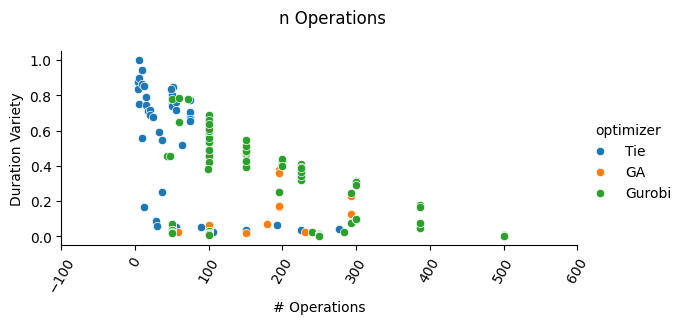

In [394]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

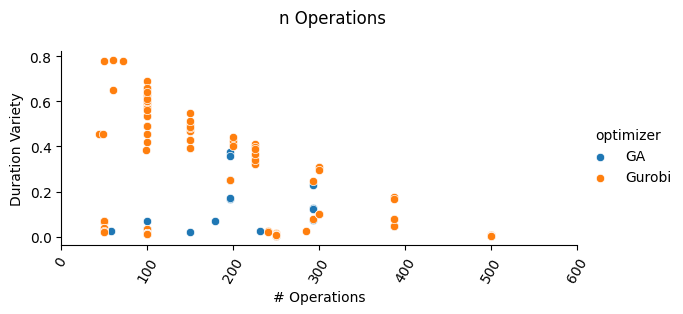

In [395]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] != 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("n Operations")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Operations')

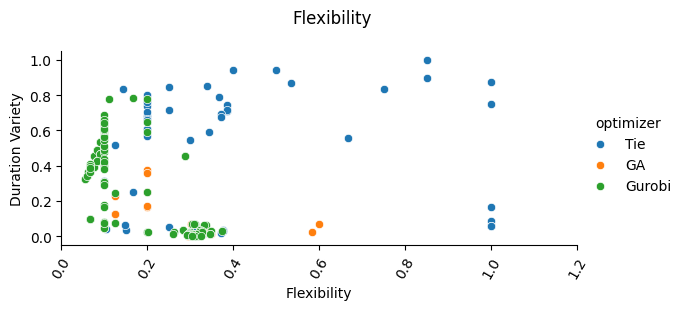

In [396]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('Flexibility')

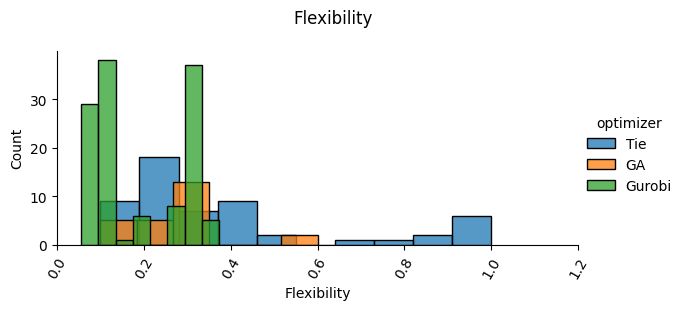

In [397]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

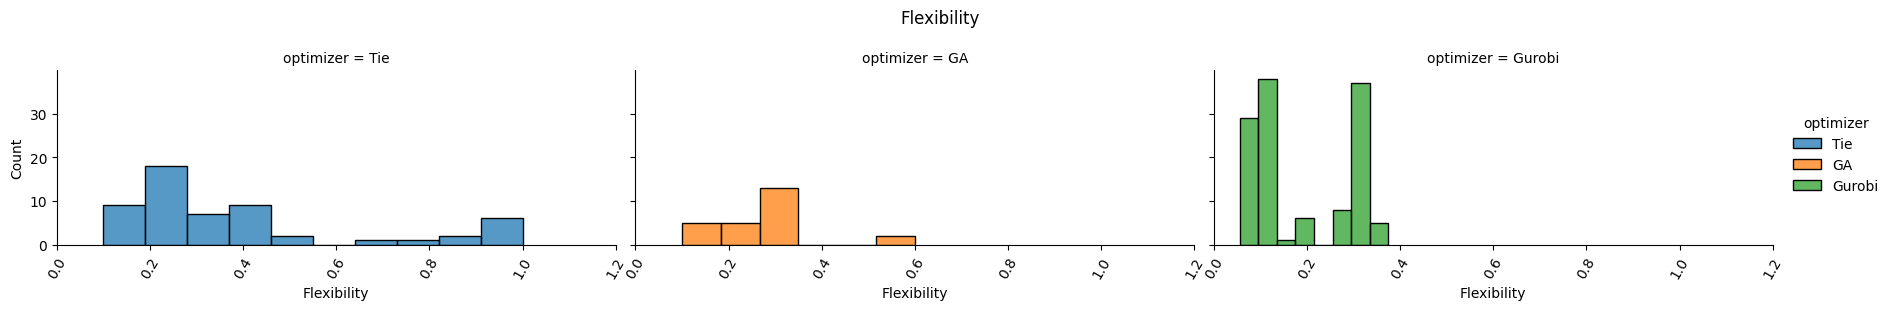

In [398]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("Flexibility")
fg.map_dataframe(sns.histplot, x='beta_flexibility').add_legend().set_xticklabels(rotation=60)

fg.set_xlabels('Flexibility')

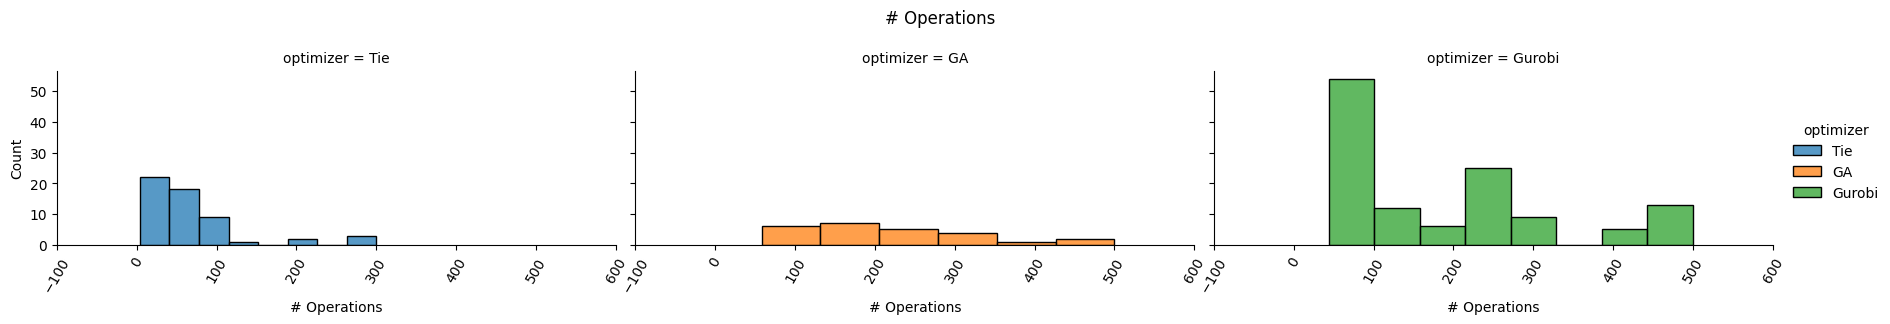

In [399]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='optimizer')
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

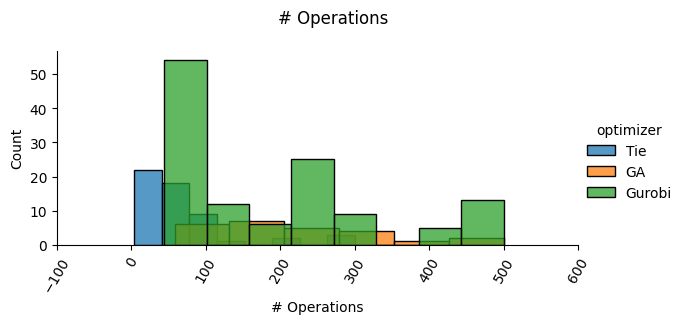

In [400]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("# Operations")
fg.map_dataframe(sns.histplot, x='n_operations').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('# Operations')

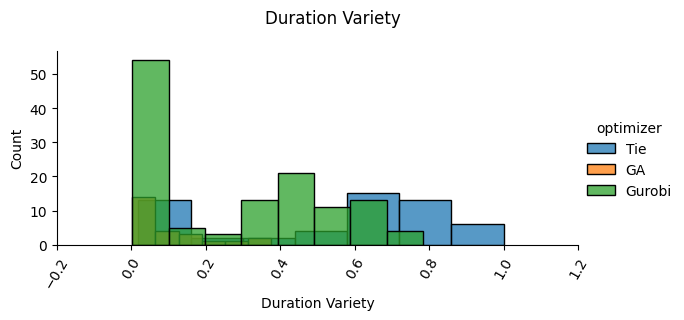

In [401]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

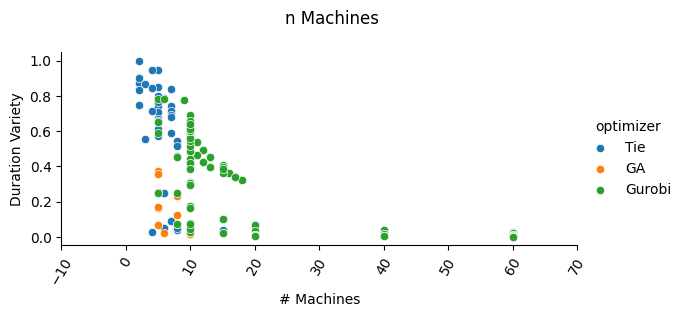

In [402]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("n Machines")
fg.map_dataframe(sns.scatterplot, x='n_machines', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_ylabels('Duration Variety')
fg.set_xlabels('# Machines')

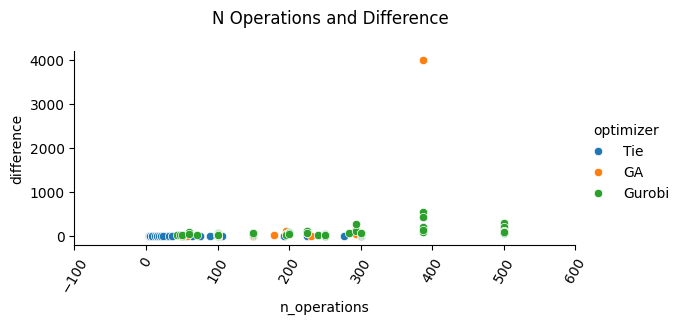

In [403]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("N Operations and Difference")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='difference').add_legend().set_xticklabels(rotation=60)

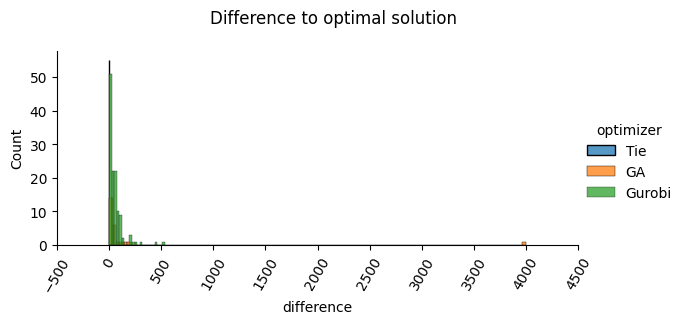

In [404]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference to optimal solution")
fg.map_dataframe(sns.histplot, x='difference').add_legend().set_xticklabels(rotation=60)

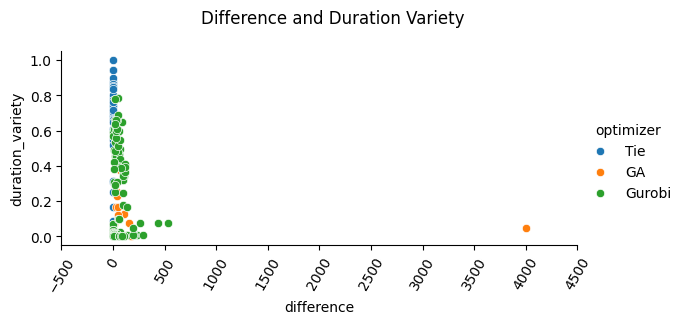

In [405]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Duration Variety")
fg.map_dataframe(sns.scatterplot, x='difference', y='duration_variety').add_legend().set_xticklabels(rotation=60)

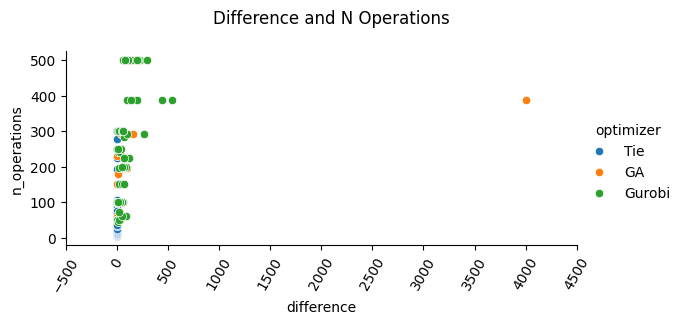

In [406]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_operations').add_legend().set_xticklabels(rotation=60)

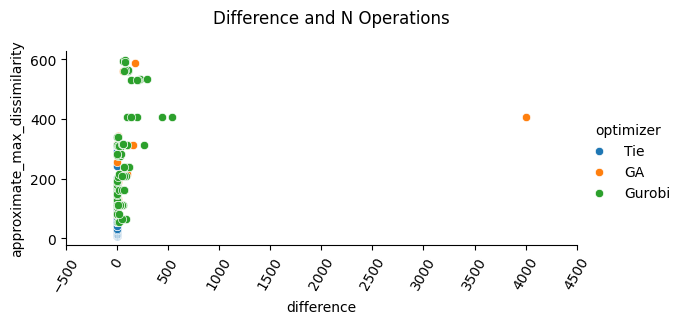

In [407]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Operations")
fg.map_dataframe(sns.scatterplot, x='difference', y='approximate_max_dissimilarity').add_legend().set_xticklabels(rotation=60)

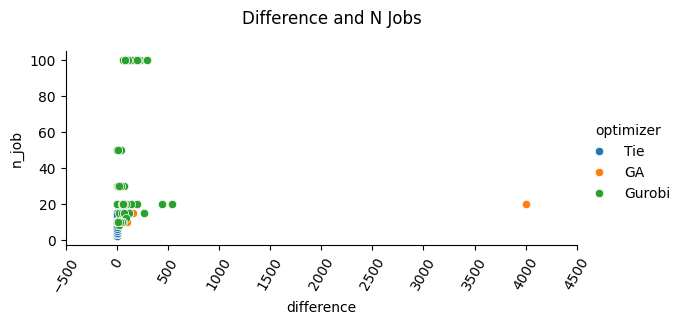

In [408]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Jobs")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_job').add_legend().set_xticklabels(rotation=60)

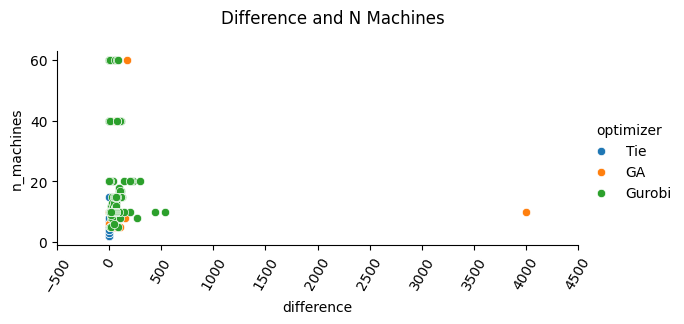

In [409]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and N Machines")
fg.map_dataframe(sns.scatterplot, x='difference', y='n_machines').add_legend().set_xticklabels(rotation=60)

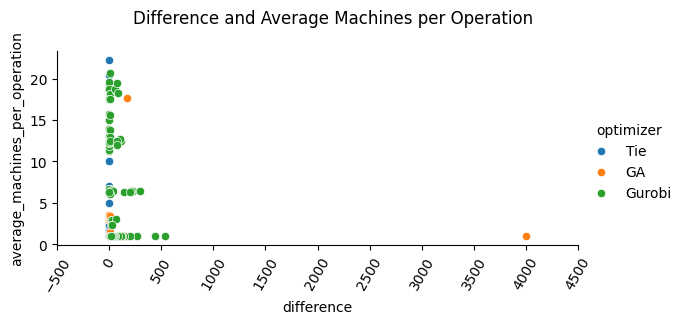

In [410]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='difference', y='average_machines_per_operation').add_legend().set_xticklabels(rotation=60)

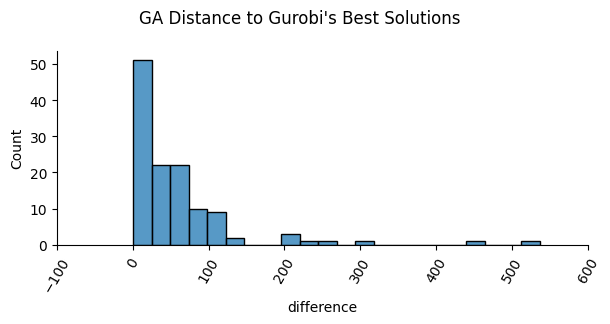

In [411]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Gurobi'], aspect=2)
fg.fig.suptitle("GA Distance to Gurobi's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

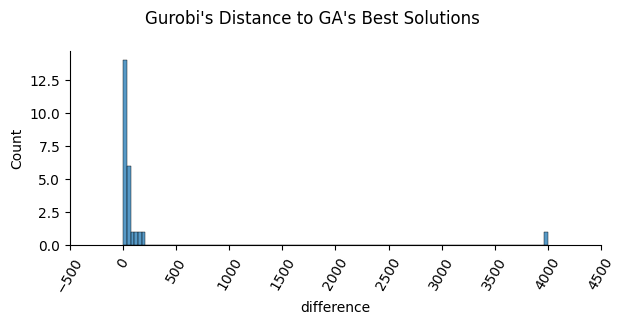

In [412]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'GA'], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

In [413]:
df_diff.loc[df_diff['difference'] > 2000]

source  instance           uid  best_objective  n_machines  n_job  \
137  3_DPpaulli        18  3_DPpaulli18          2965.0          10     20   

     average_machines_per_operation  n_operations  average_operations_per_job  \
137                             1.0           387                       19.35   

     beta_flexibility  approximate_max_dissimilarity  duration_variety  \
137               0.1                         406.35          0.045853   

     fevals_GA  fevals_Gurobi  fevals_difference  abs_fevals_difference  \
137     188630            630            -188000                 188000   

     log_fevals_difference optimizer  difference source_abbreviation  
137             -12.144197        GA      4000.0                   3

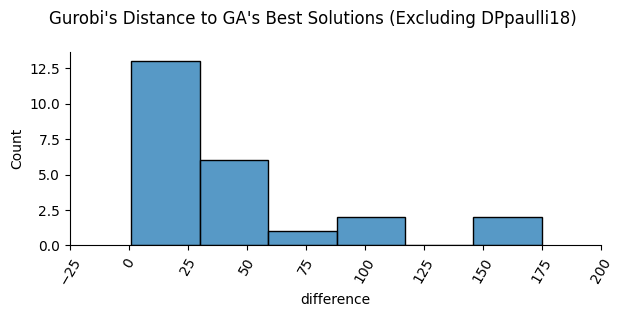

In [414]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') & (df_diff['difference'] < 4000)], aspect=2)
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='difference',).add_legend().set_xticklabels(rotation=60)

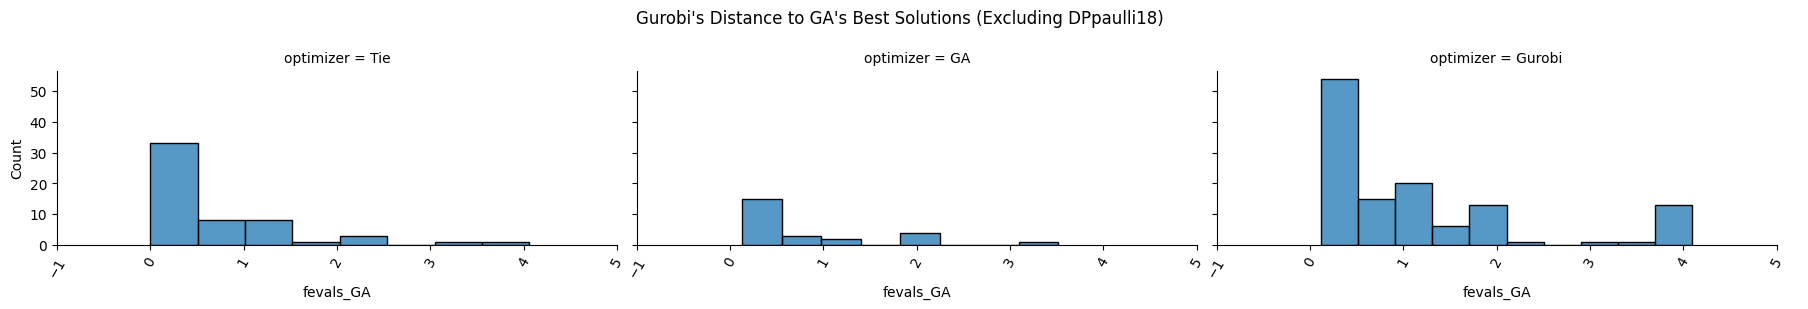

In [415]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_GA',).add_legend().set_xticklabels(rotation=60)

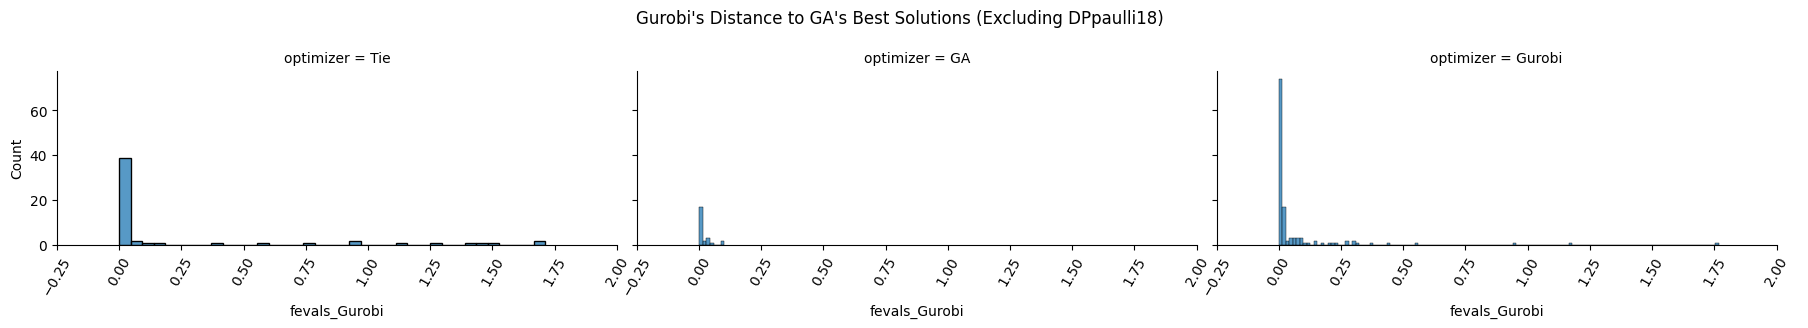

In [416]:
fg = sns.FacetGrid(data=df_diff, aspect=2, col='optimizer')
fg.fig.suptitle("Gurobi's Distance to GA's Best Solutions (Excluding DPpaulli18)")
fg.map_dataframe(sns.histplot, x='fevals_Gurobi',).add_legend().set_xticklabels(rotation=60)

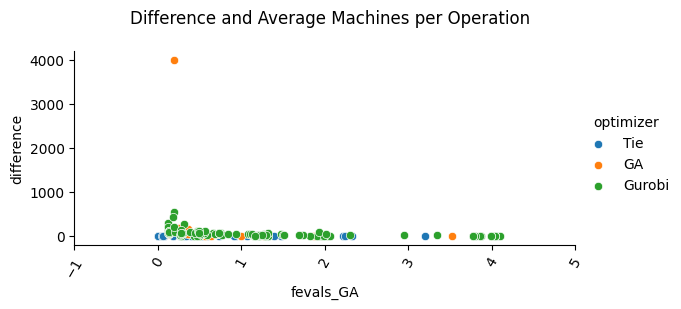

In [417]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

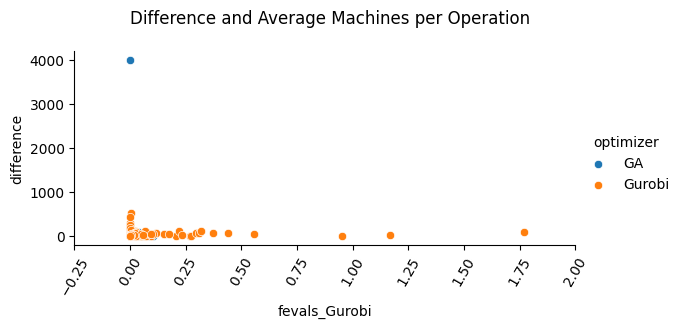

In [418]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_Gurobi', y='difference').add_legend().set_xticklabels(rotation=60)

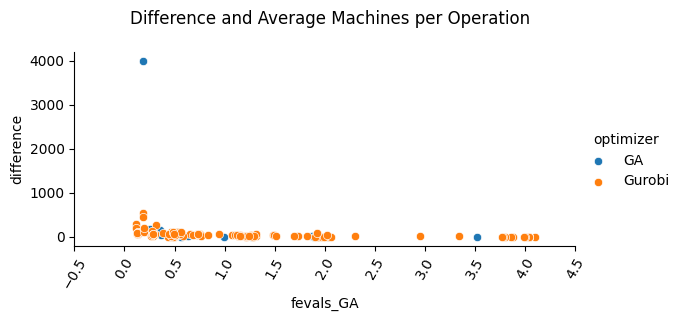

In [419]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') | (df_diff['optimizer'] == 'Gurobi')], hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='difference').add_legend().set_xticklabels(rotation=60)

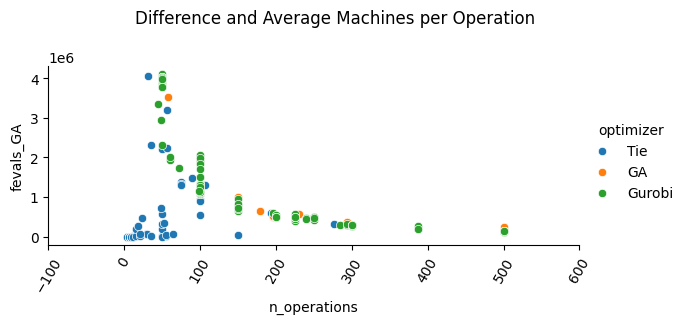

In [420]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA').add_legend().set_xticklabels(rotation=60)

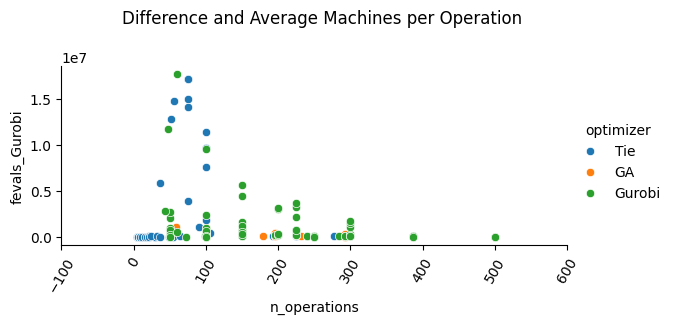

In [421]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi').add_legend().set_xticklabels(rotation=60)

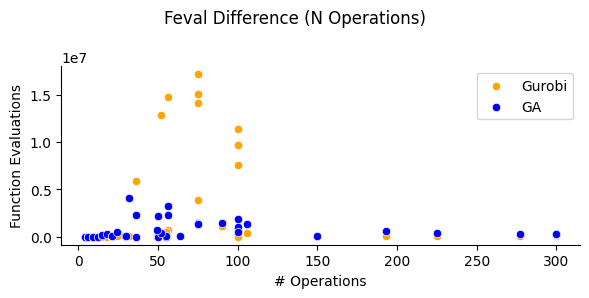

In [422]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], aspect=2)
fg.fig.suptitle("Feval Difference (N Operations)")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('# Operations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

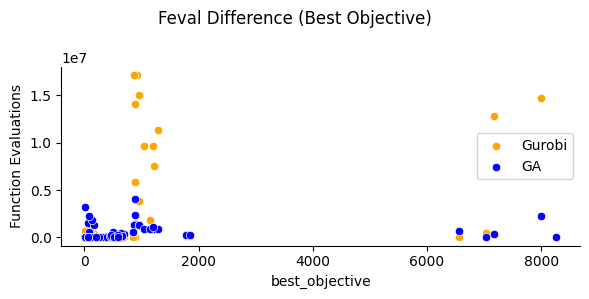

In [423]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Best Objective)")
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='best_objective', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

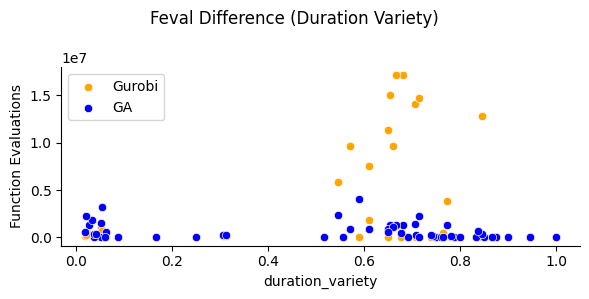

In [424]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Duration Variety)")
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='duration_variety', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

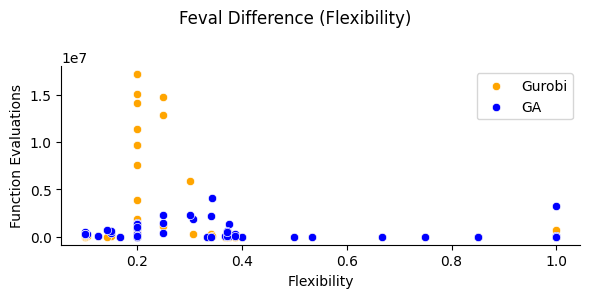

In [425]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Flexibility)")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

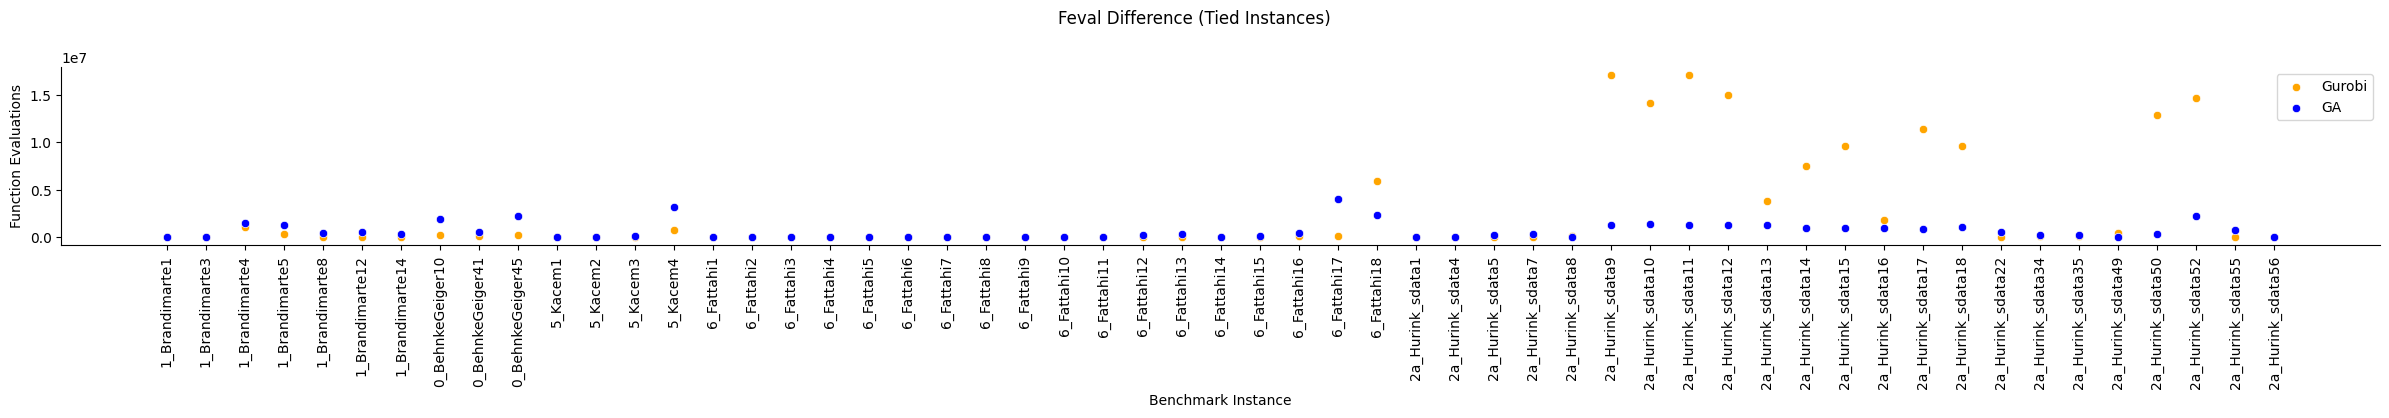

In [426]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Tied Instances)")
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Benchmark Instance')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

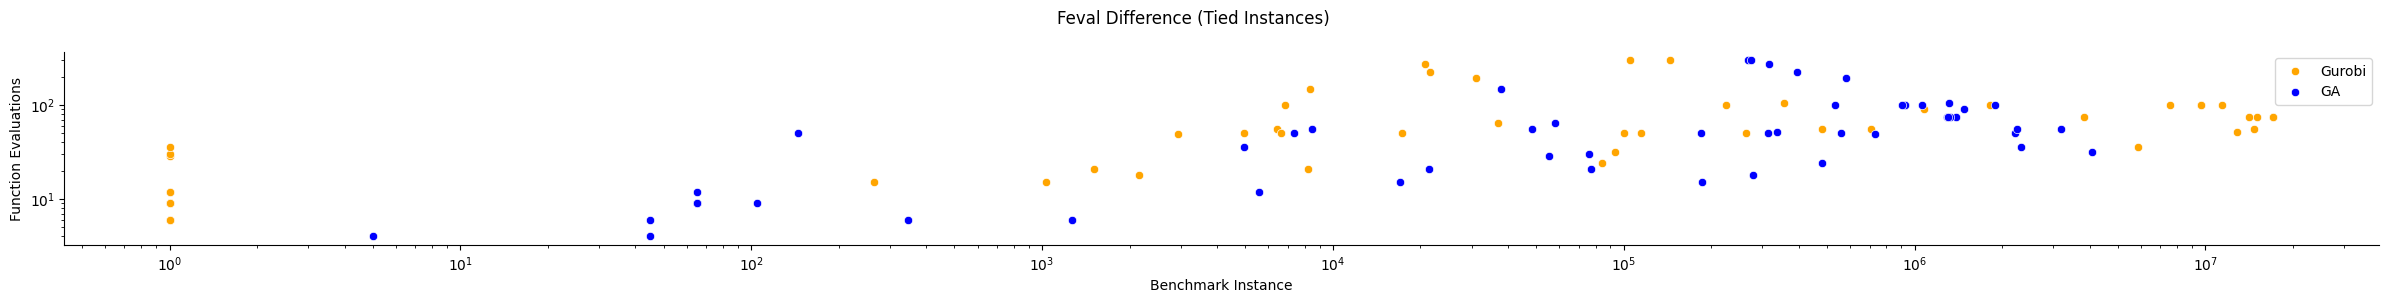

In [427]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Tied Instances)")
fg.map_dataframe(sns.scatterplot, x='fevals_Gurobi', y='n_operations', color='orange')
fg.map_dataframe(sns.scatterplot, x='fevals_GA', y='n_operations', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Benchmark Instance')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

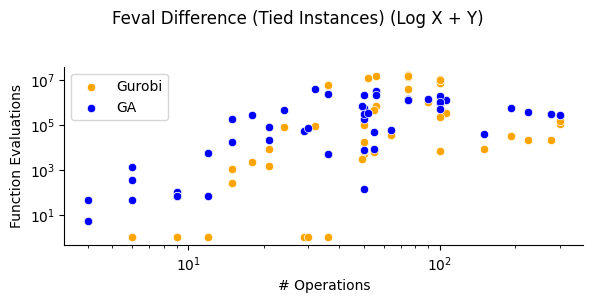

In [428]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Tied Instances) (Log X + Y)")
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='n_operations', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('# Operations')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

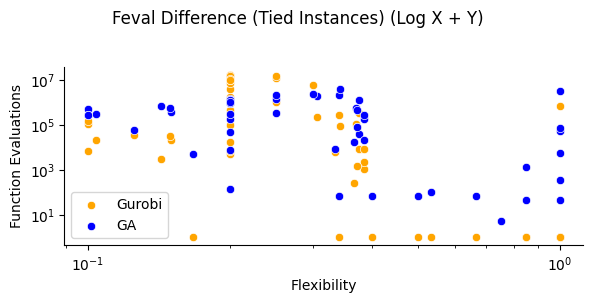

In [429]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] == 'Tie'], hue='optimizer', aspect=2)
fg.fig.suptitle("Feval Difference (Tied Instances) (Log X + Y)")
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='beta_flexibility', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
#fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

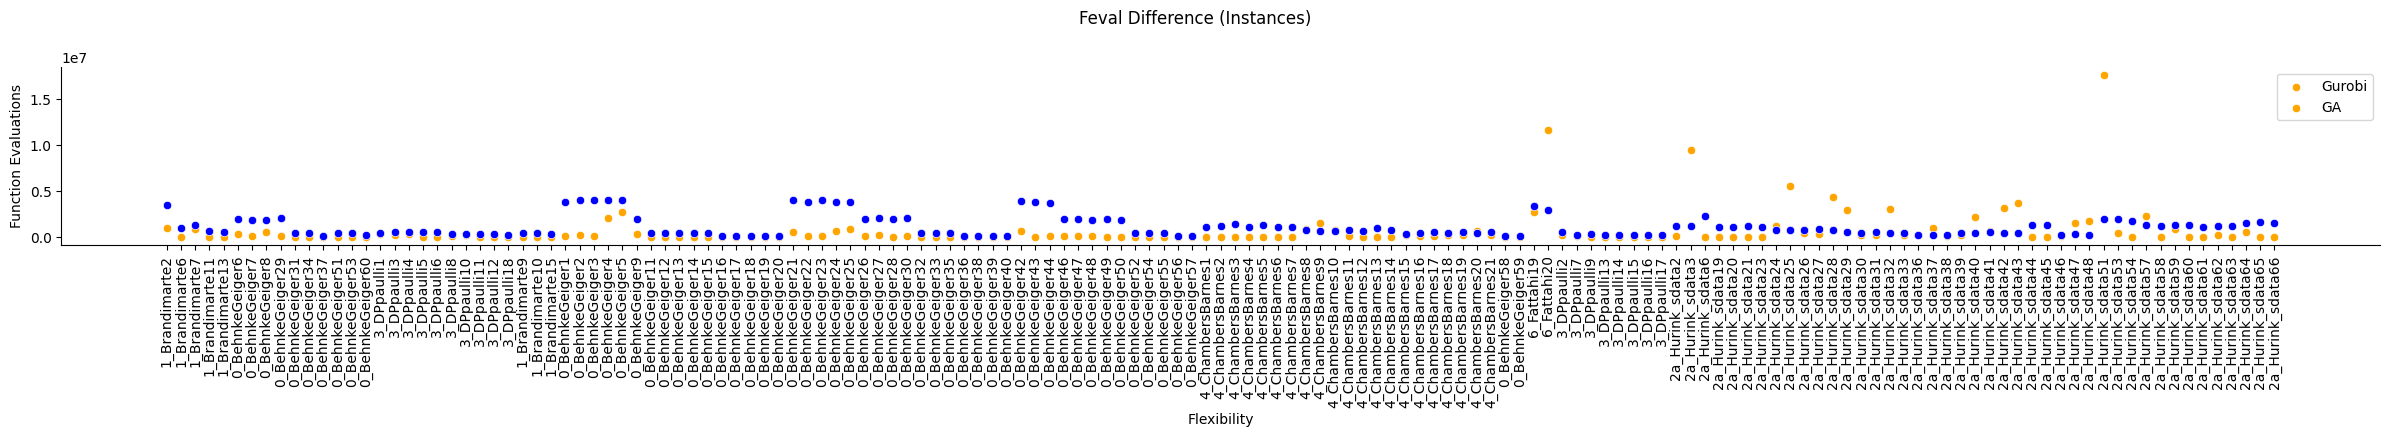

In [430]:
fg = sns.FacetGrid(data=df_diff.loc[df_diff['optimizer'] != 'Tie'], hue='optimizer', aspect=8)
fg.fig.suptitle("Feval Difference (Instances)")
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='uid', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Flexibility')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.show(fg)

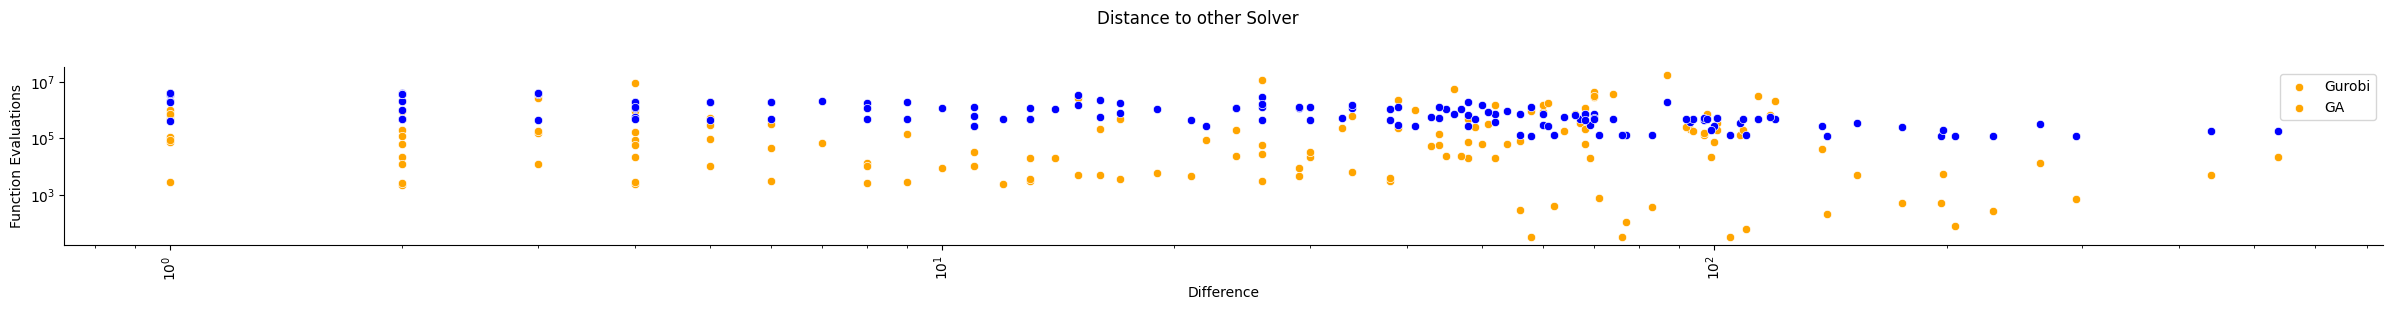

In [431]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=8)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi', color='orange')
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

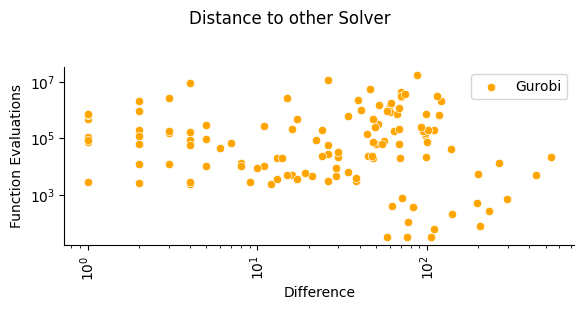

In [432]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Gurobi') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=2)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi', color='orange')
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

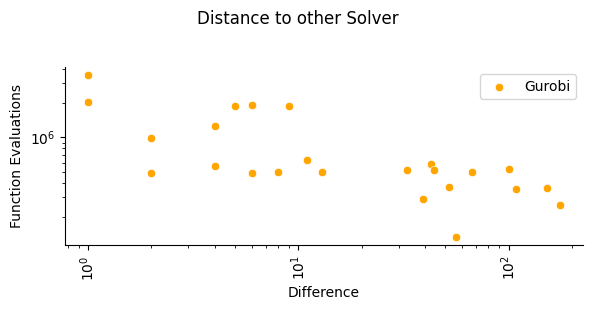

In [433]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'GA') & (df_diff['uid'] != '3_DPpaulli18')], hue='optimizer', aspect=2)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='orange')
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
fg.set_xticklabels(rotation=90)
import matplotlib.pyplot as plt
plt.legend(labels=['Gurobi', 'GA'])
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

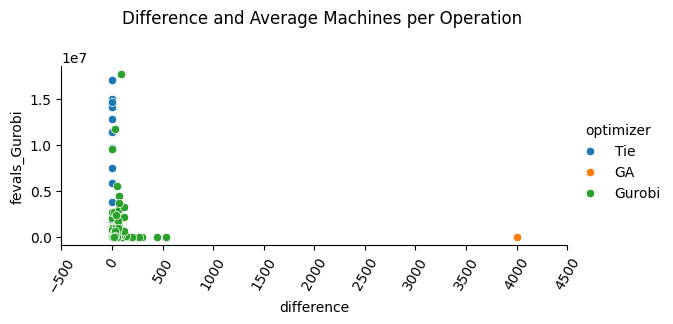

In [434]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Difference and Average Machines per Operation")
fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_Gurobi').add_legend().set_xticklabels(rotation=60)

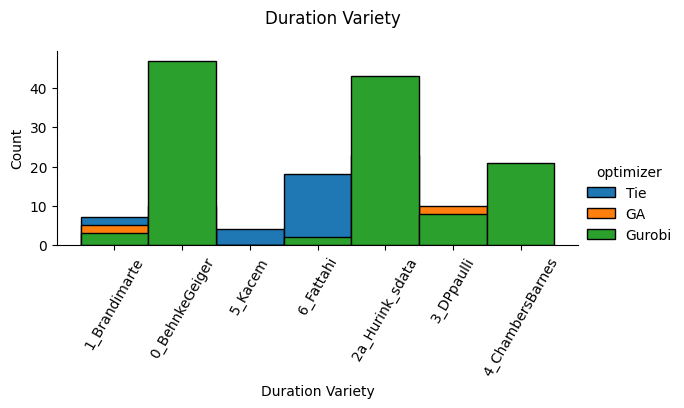

In [435]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='source', alpha=1, ).add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

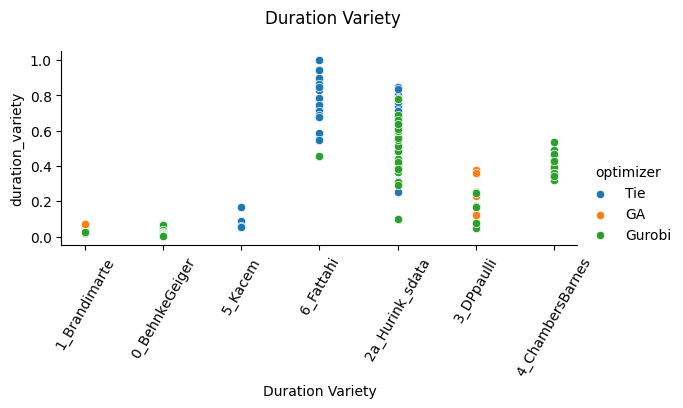

In [436]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.scatterplot, x='source', y='duration_variety').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

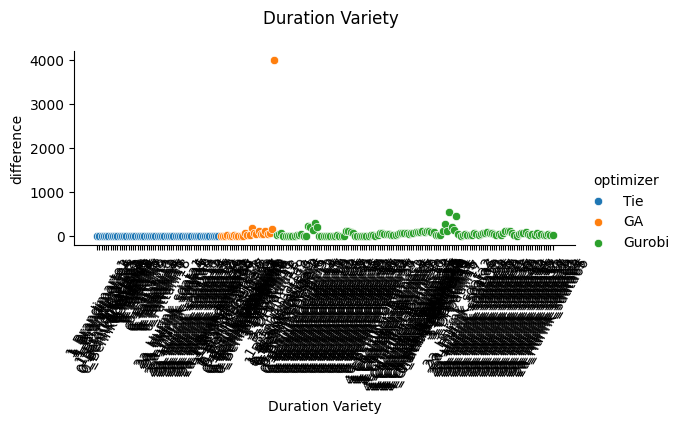

In [437]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.scatterplot, x='uid', y='difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')

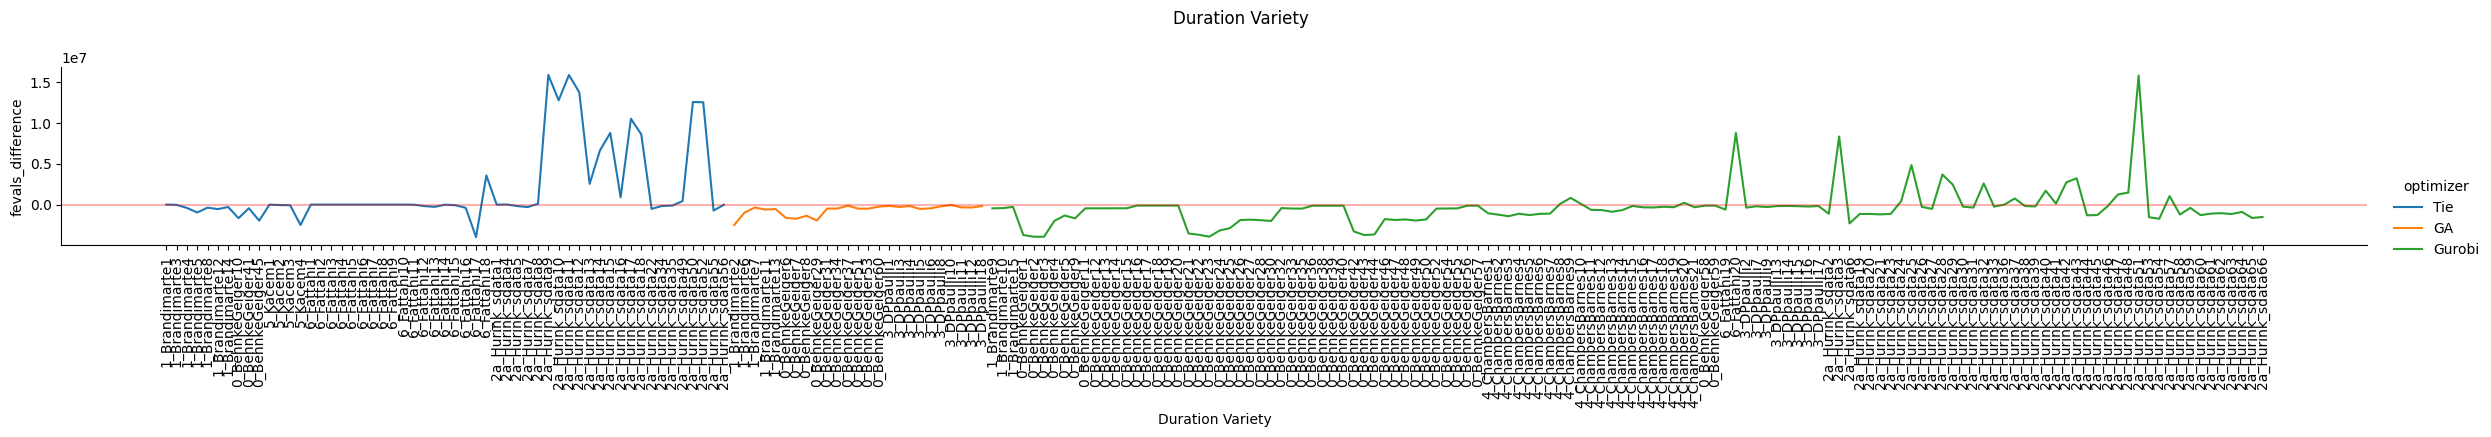

In [438]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=90)
fg.set_xlabels('Duration Variety')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
#plt.tight_layout()
#plt.yscale('log')
plt.show(fg)

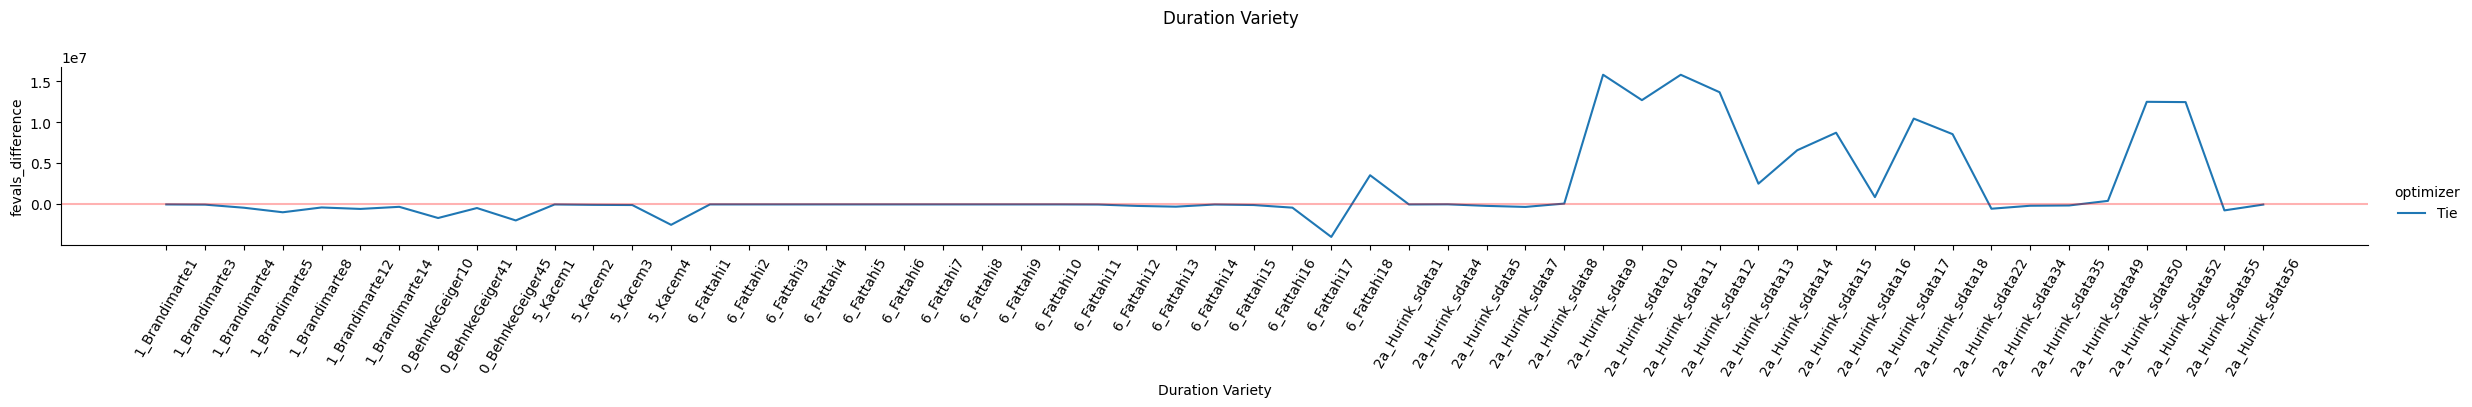

In [439]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

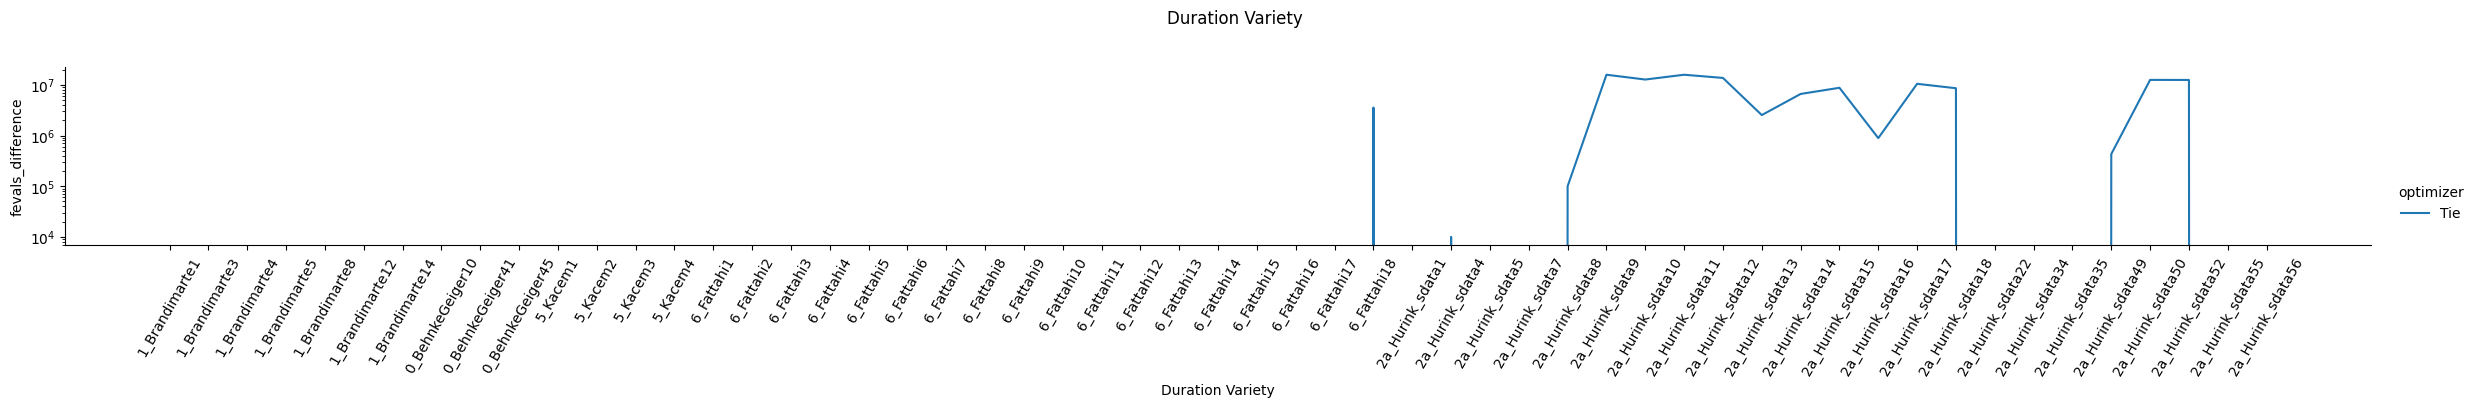

In [440]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

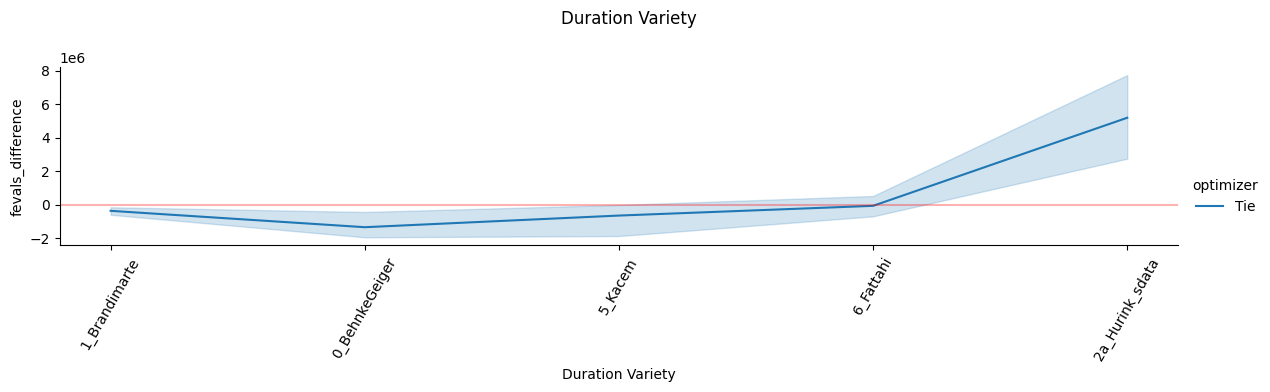

In [441]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=4)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='source', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

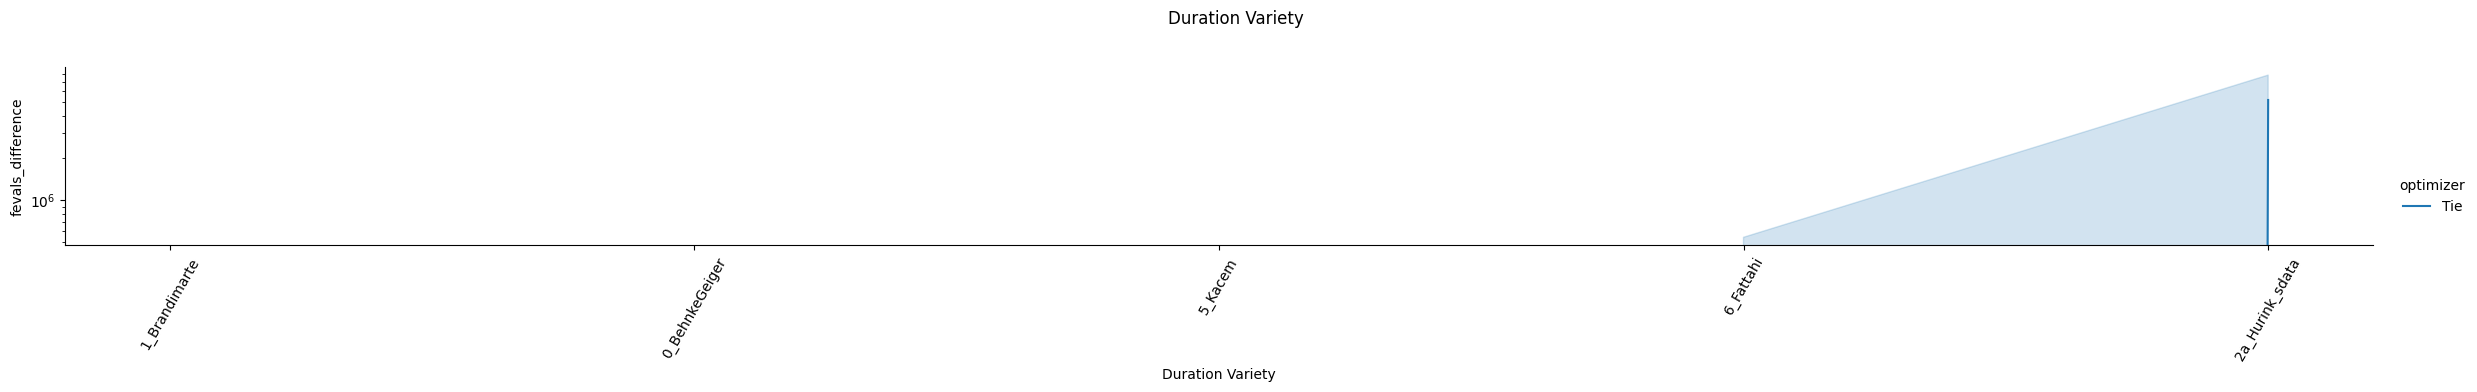

In [442]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=8)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='source', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

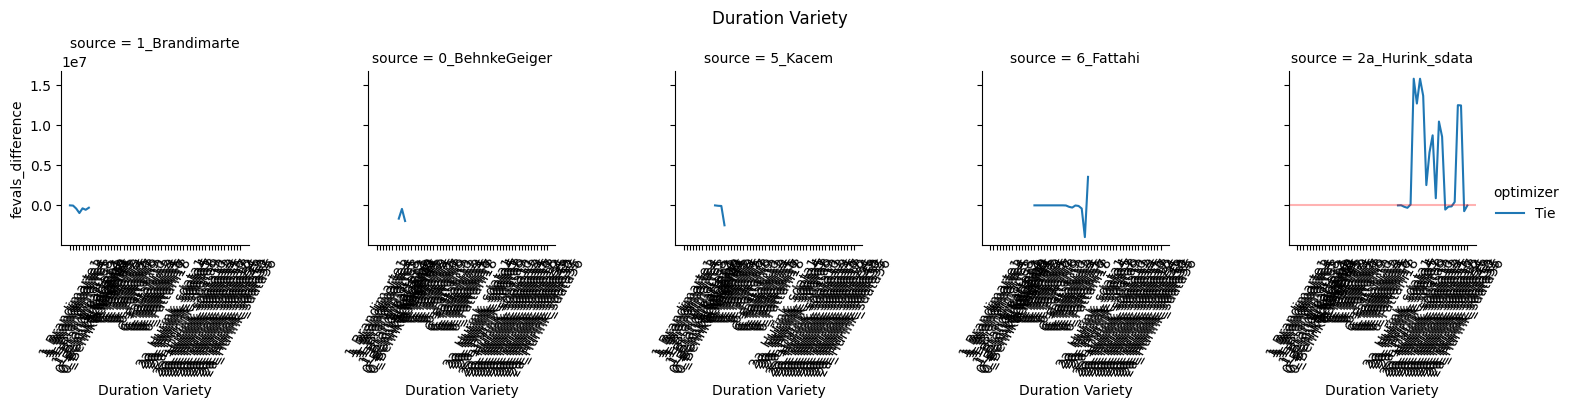

In [443]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=1, col='source')
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
#plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

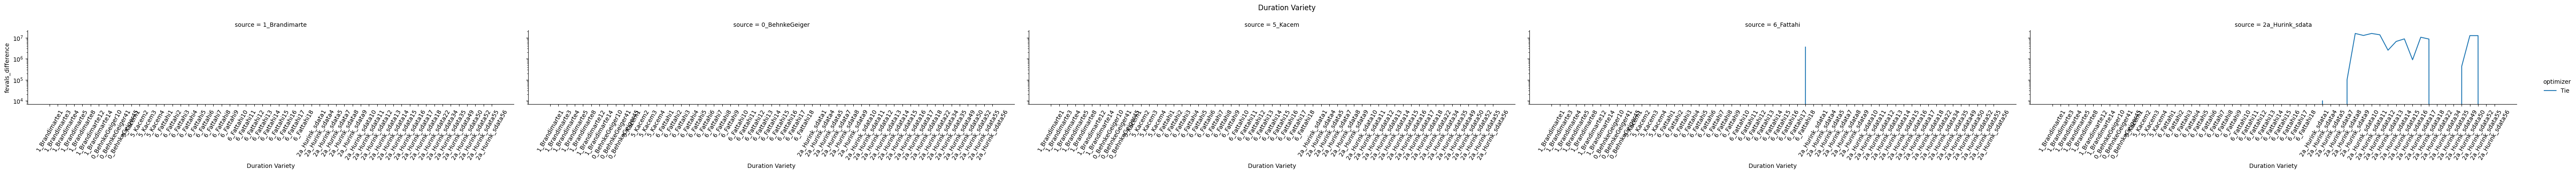

In [444]:
fg = sns.FacetGrid(data=df_diff.loc[(df_diff['optimizer'] == 'Tie')], hue='optimizer', aspect=4, col='source')
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.lineplot, x='uid', y='fevals_difference').add_legend().set_xticklabels(rotation=60)
fg.set_xlabels('Duration Variety')
plt.yscale('log')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.show(fg)

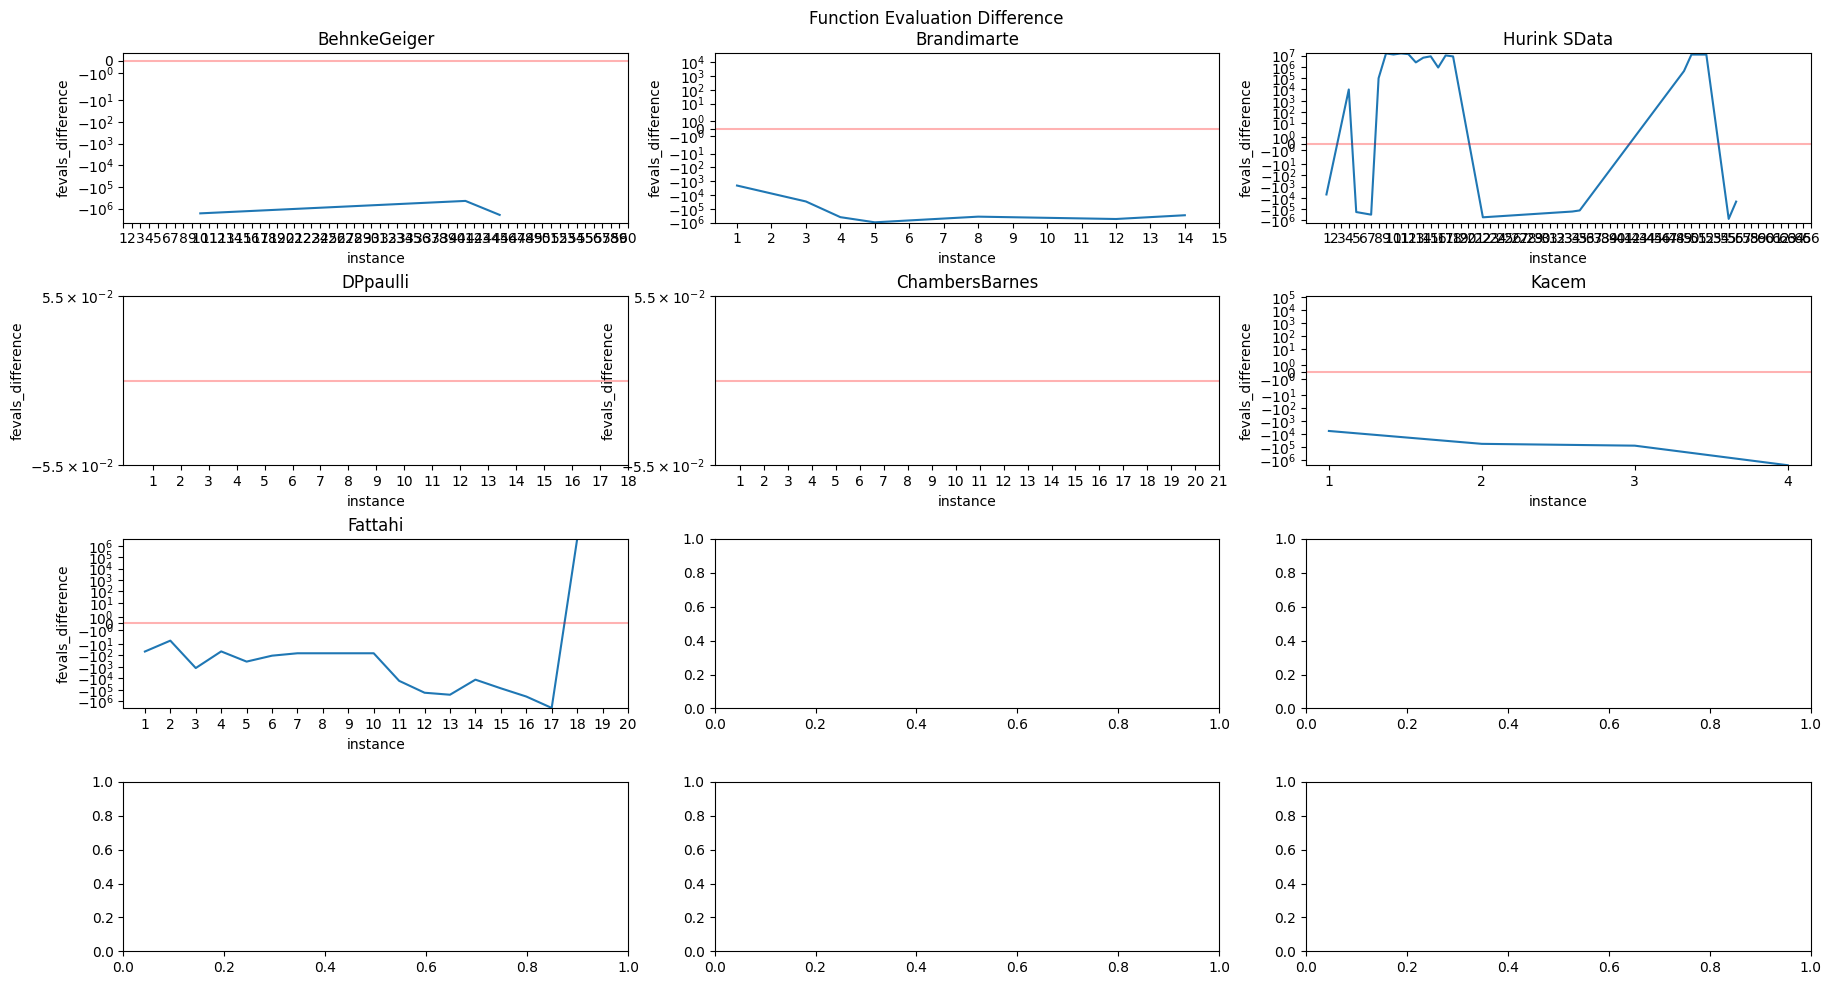

In [445]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

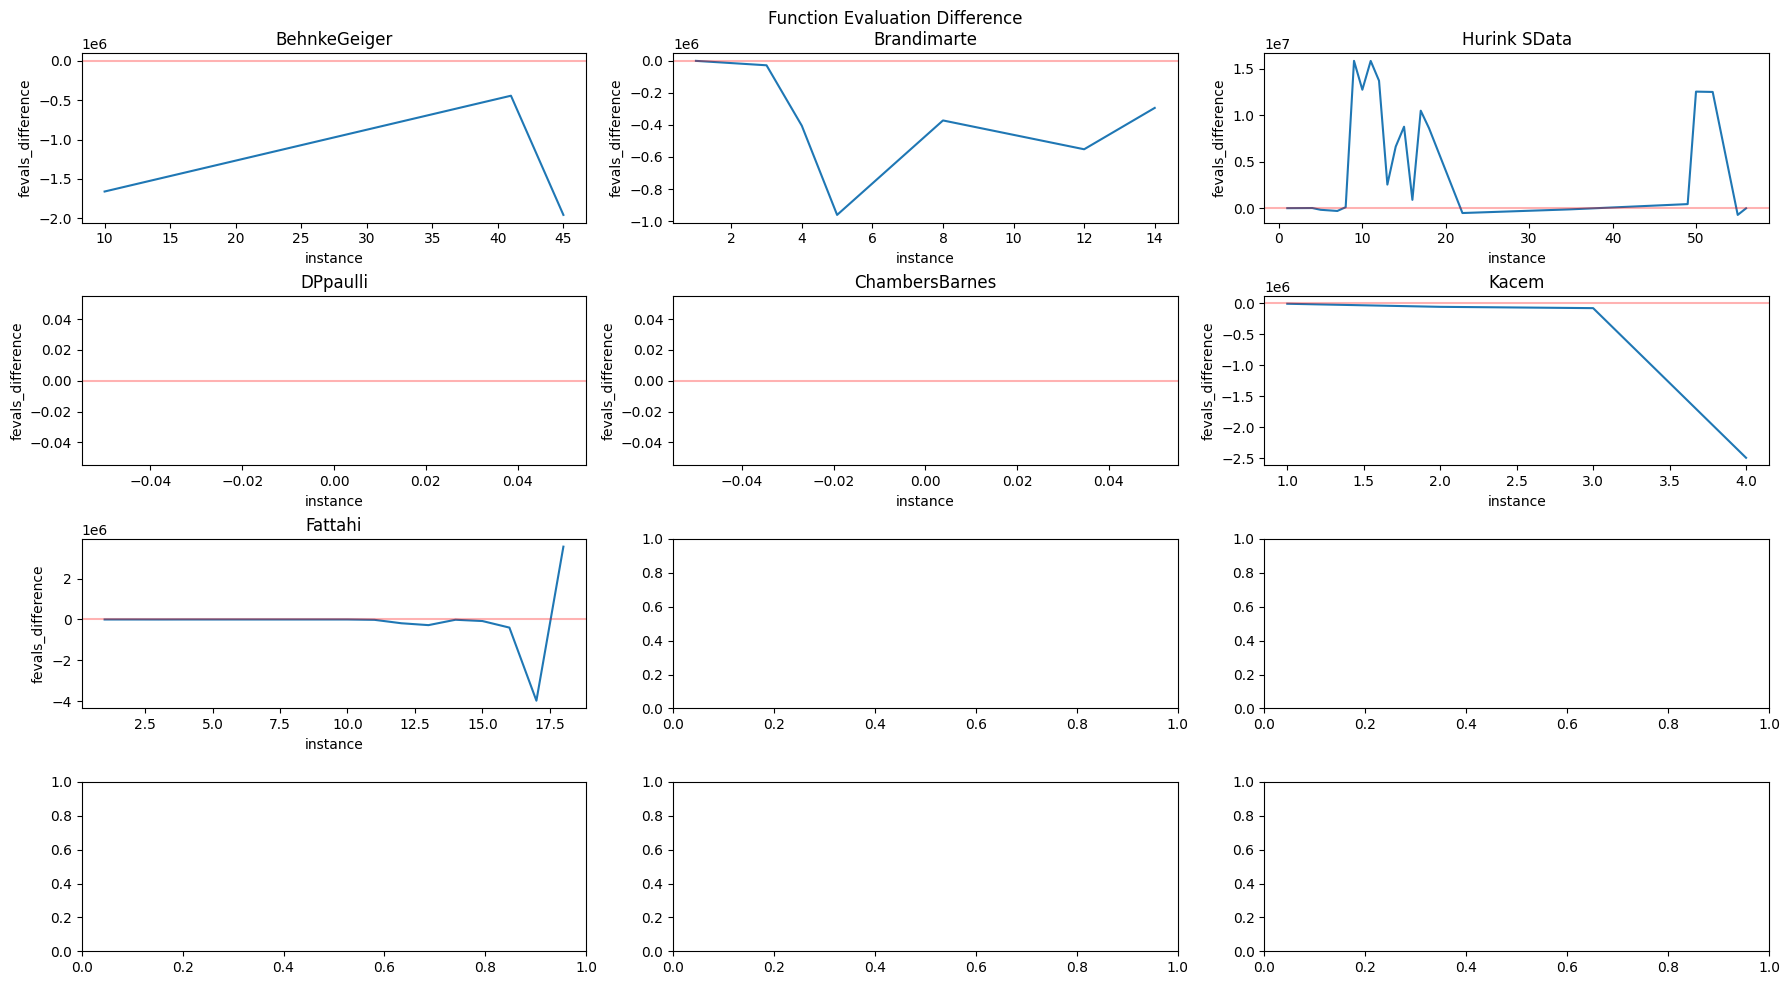

In [446]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

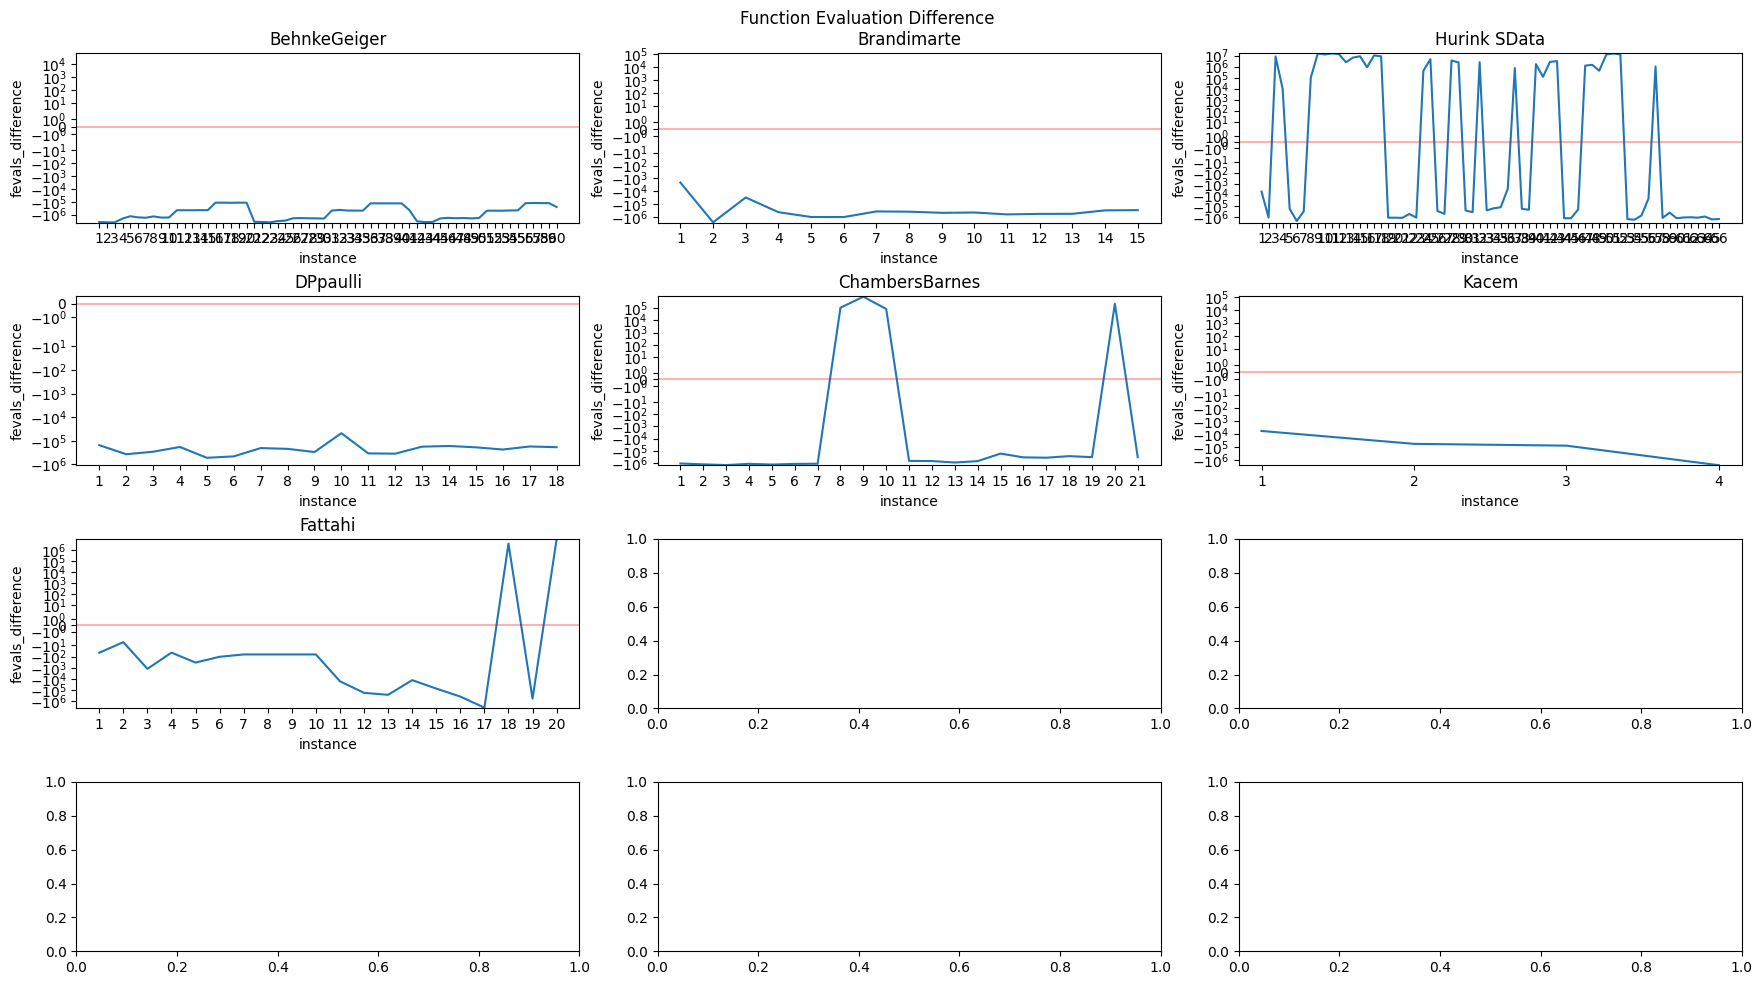

In [447]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

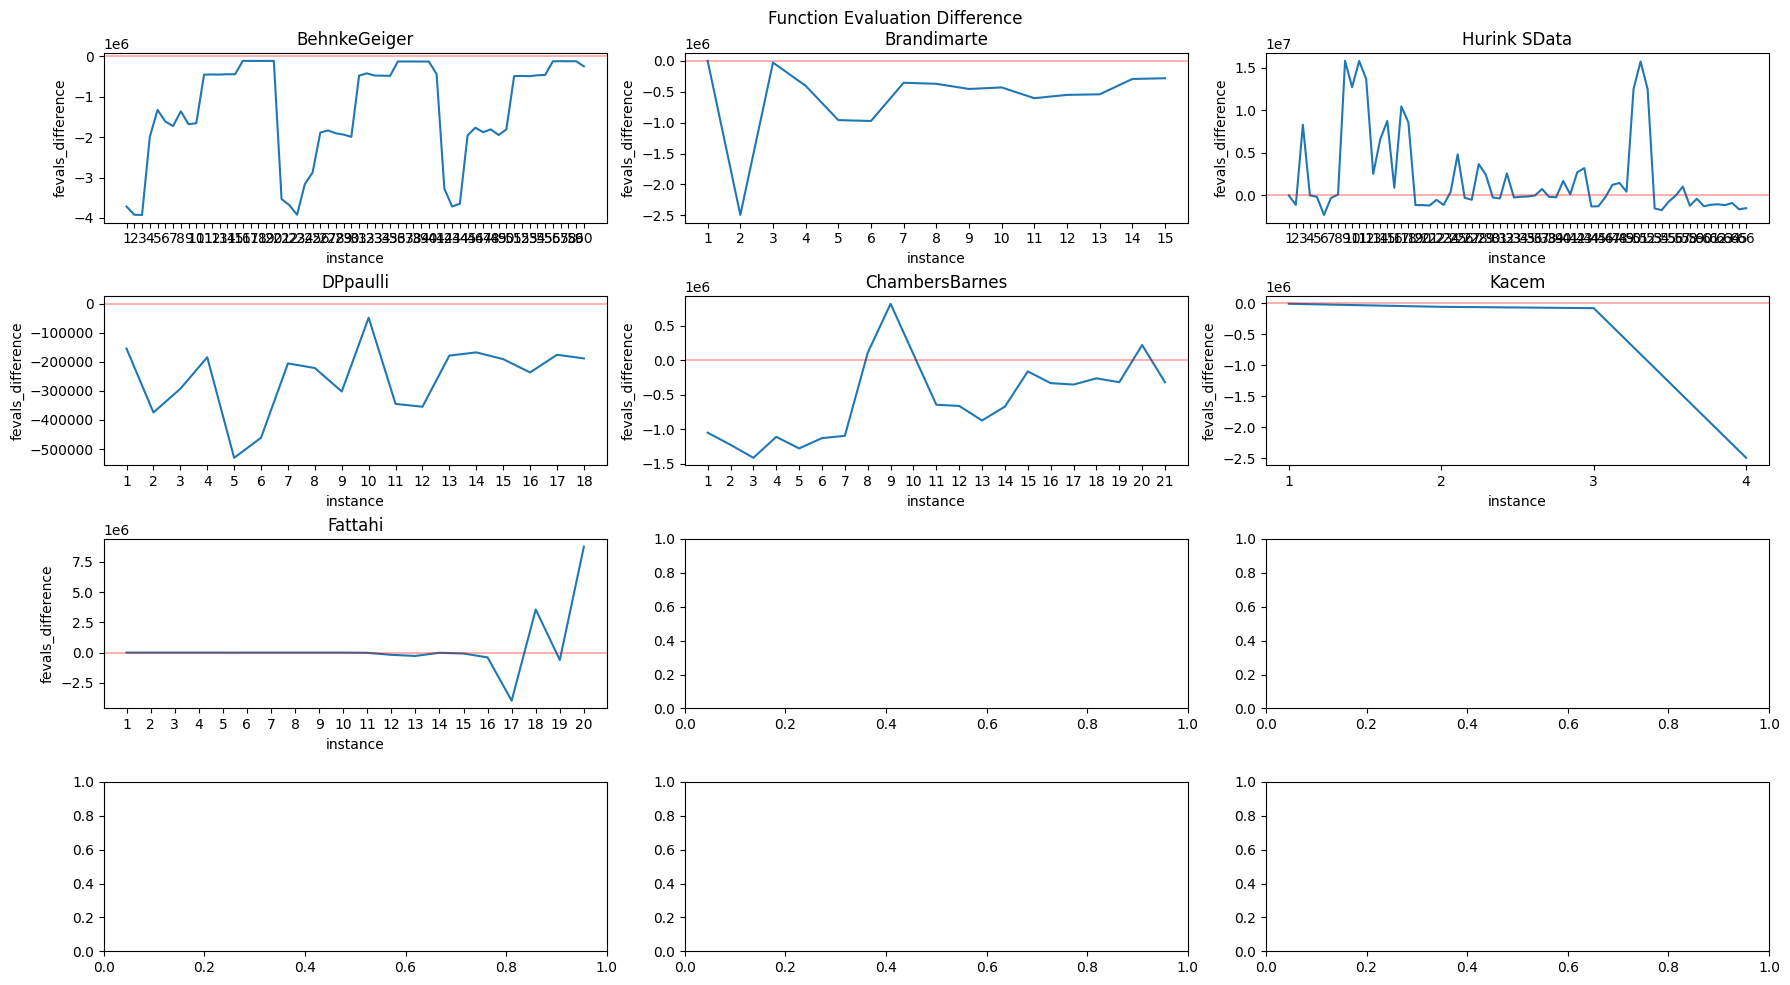

In [448]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.lineplot(data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
plt.sca(axes[0,0])
plt.xticks(range(1, 61))
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,1])
plt.xticks(range(1, 16))
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[0,2])
plt.xticks(range(1, 67))
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,0])
plt.xticks(range(1, 19))
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,1])
plt.xticks(range(1, 22))
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[1,2])
plt.xticks(range(1, 5))
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.sca(axes[2,0])
plt.xticks(range(1, 21))
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

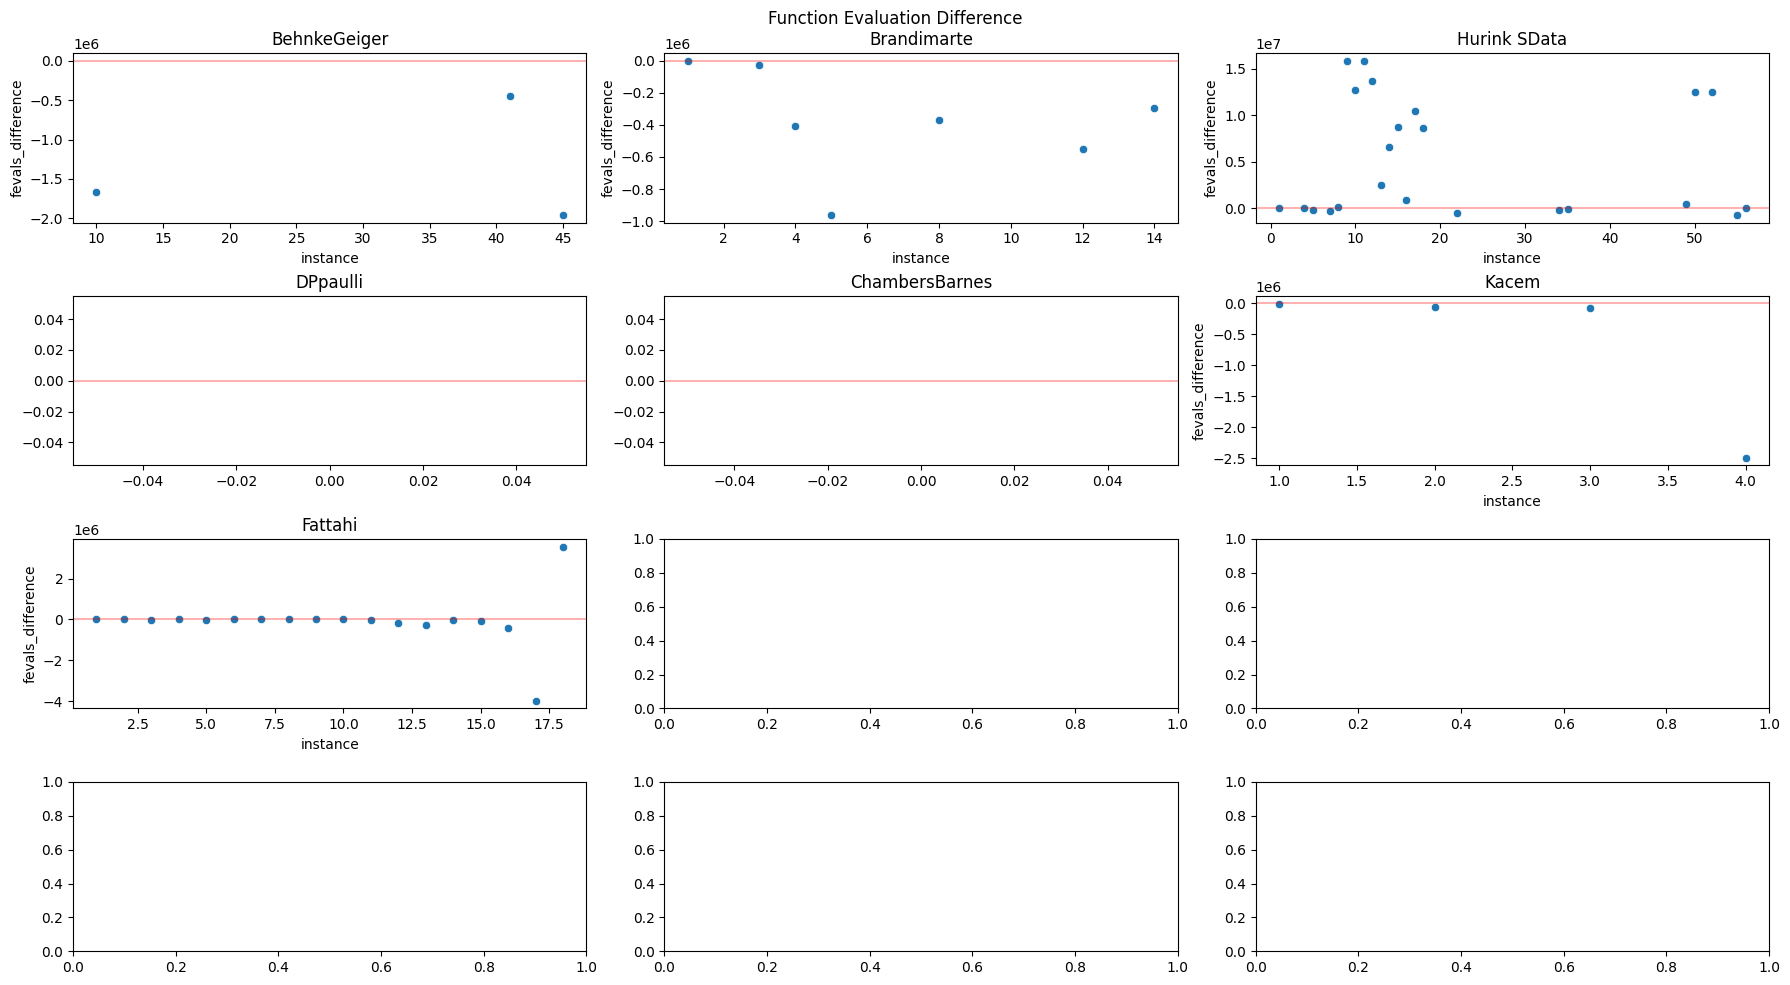

In [449]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
#axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
#axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
#axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
#axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
#axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
#axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

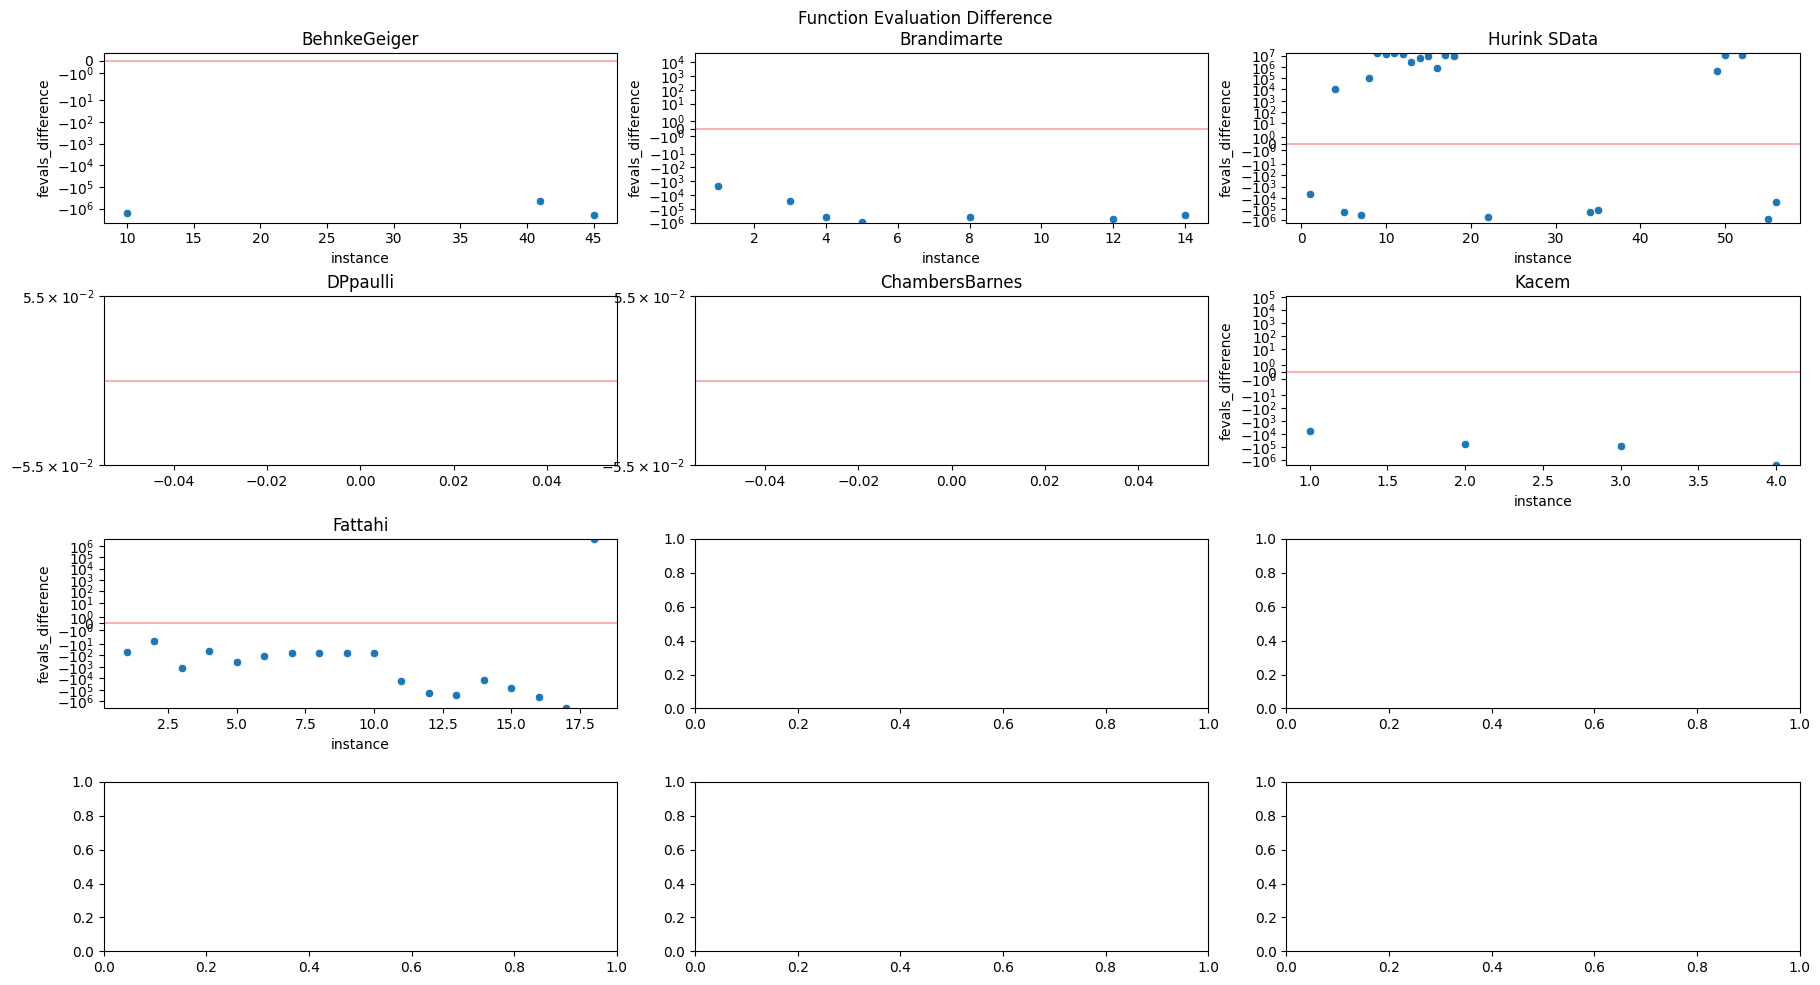

In [450]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='instance', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='instance', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='instance', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='instance', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='instance', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '5_Kacem')], x='instance', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] == 'Tie') & (df_diff['source'] == '6_Fattahi')], x='instance', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
axes[0,0].set_yscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

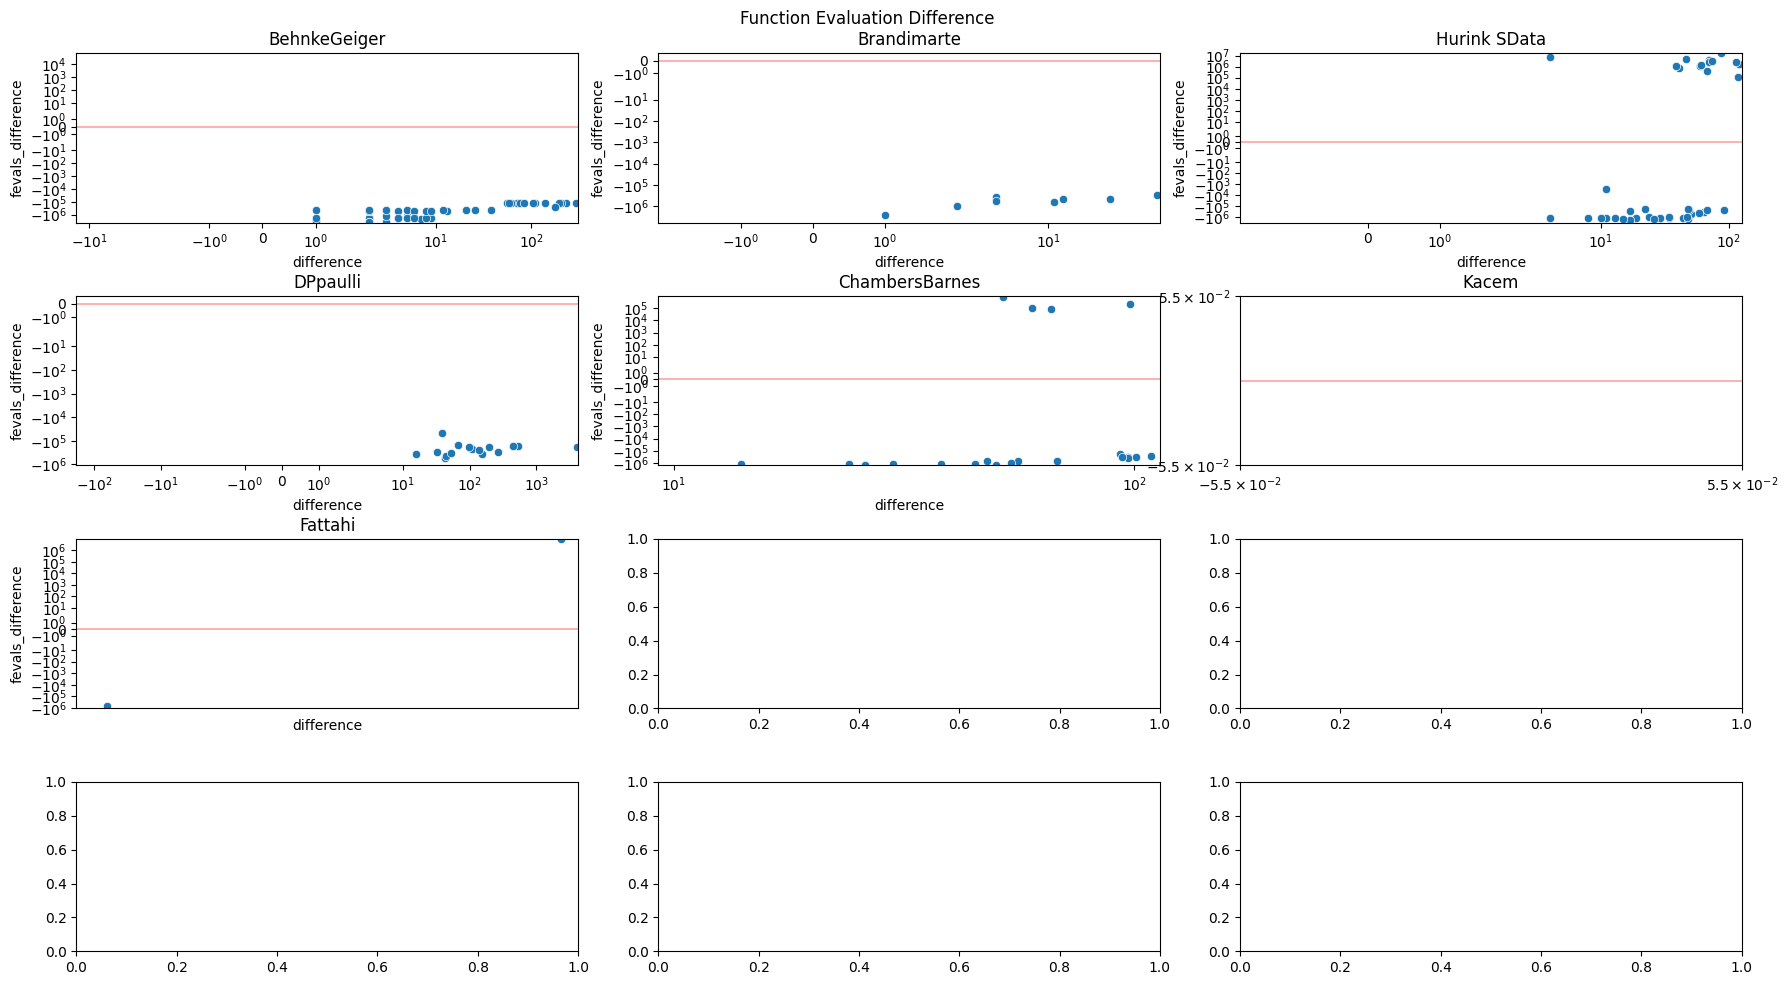

In [451]:
def absolute(x):
    return abs(x)

def inverse(x):
    return -x

fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='fevals_difference', ax=axes[0,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='difference', y='fevals_difference', ax=axes[0,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='fevals_difference', ax=axes[0,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='difference', y='fevals_difference', ax=axes[1,0])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='difference', y='fevals_difference', ax=axes[1,1])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '5_Kacem')], x='difference', y='fevals_difference', ax=axes[1,2])
sns.scatterplot(data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '6_Fattahi')], x='difference', y='fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('symlog')
axes[0,0].set_xscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].set_xscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].set_xscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].set_xscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].set_xscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].set_xscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].set_xscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

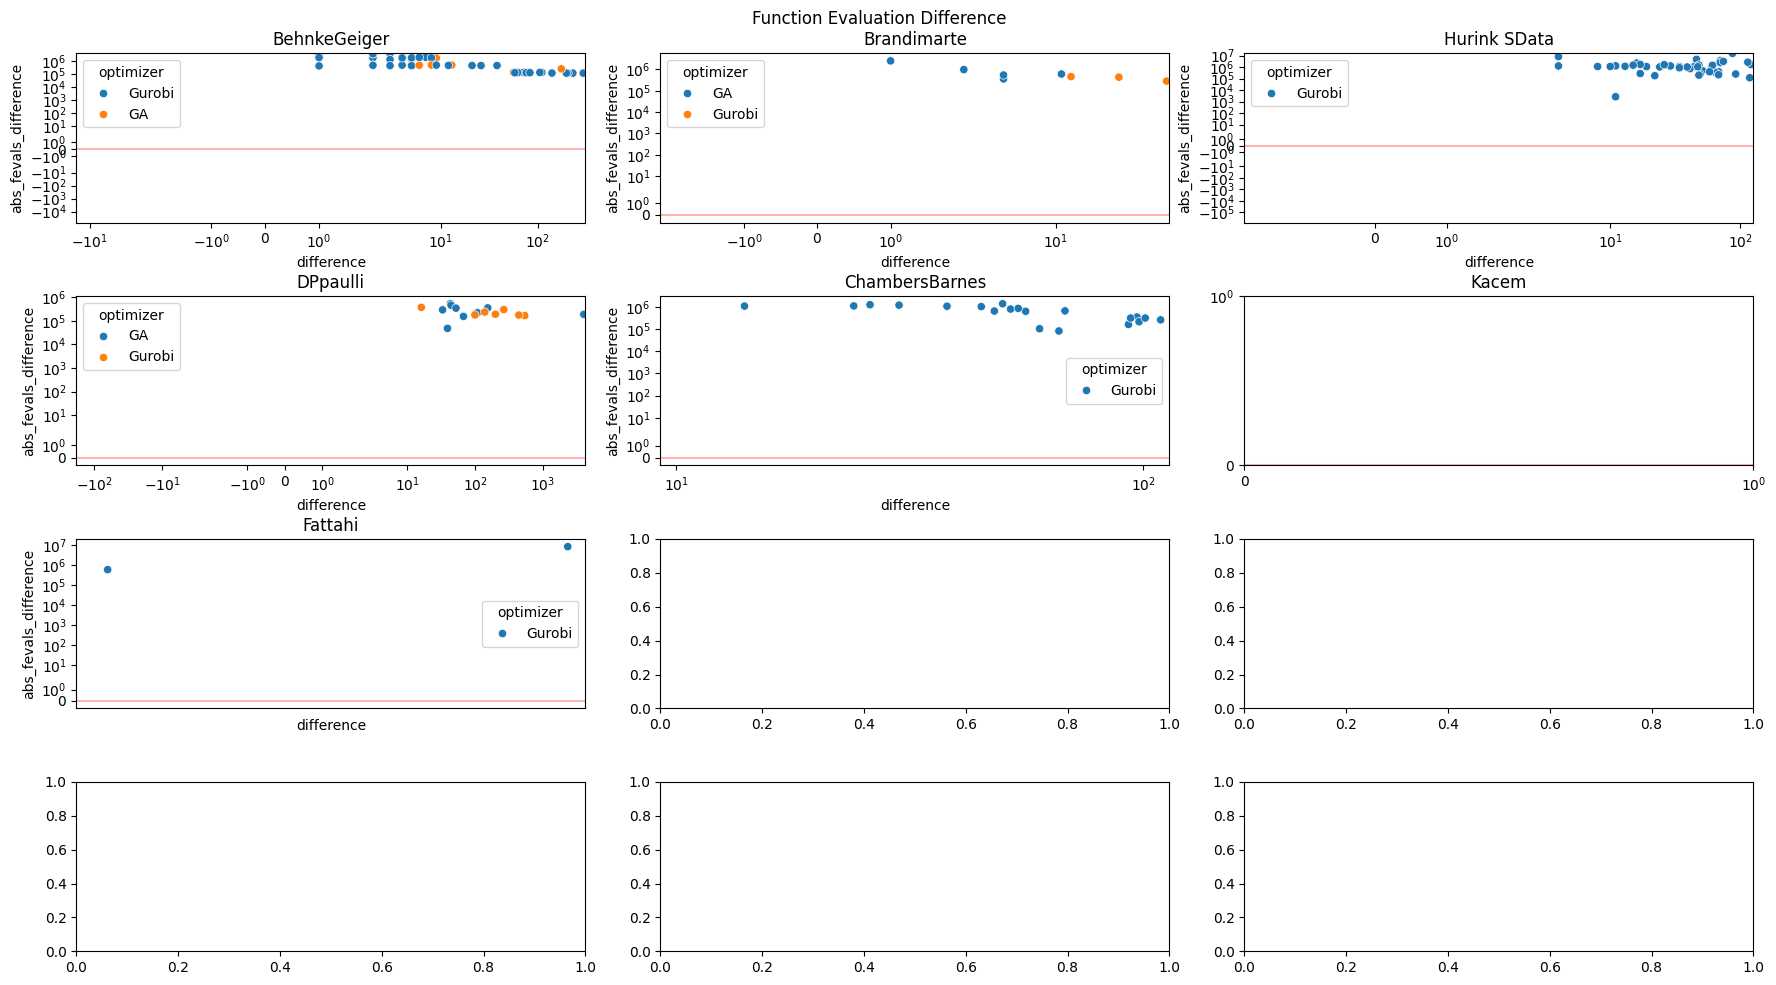

In [452]:
def absolute(x):
    return abs(x)

def inverse(x):
    return -x

fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='abs_fevals_difference', ax=axes[0,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '1_Brandimarte')], x='difference', y='abs_fevals_difference', ax=axes[0,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='abs_fevals_difference', ax=axes[0,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '3_DPpaulli')], x='difference', y='abs_fevals_difference', ax=axes[1,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '4_ChambersBarnes')], x='difference', y='abs_fevals_difference', ax=axes[1,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '5_Kacem')], x='difference', y='abs_fevals_difference', ax=axes[1,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['optimizer'] != 'Tie') & (df_diff['source'] == '6_Fattahi')], x='difference', y='abs_fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('symlog')
axes[0,0].set_xscale('symlog')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('symlog')
axes[0,1].set_xscale('symlog')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('symlog')
axes[0,2].set_xscale('symlog')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('symlog')
axes[1,0].set_xscale('symlog')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('symlog')
axes[1,1].set_xscale('symlog')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('symlog')
axes[1,2].set_xscale('symlog')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('symlog')
axes[2,0].set_xscale('symlog')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

C:\Users\huda\AppData\Local\Temp\ipykernel_11600\2456426557.py:35: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[1,2].set_xscale('log')


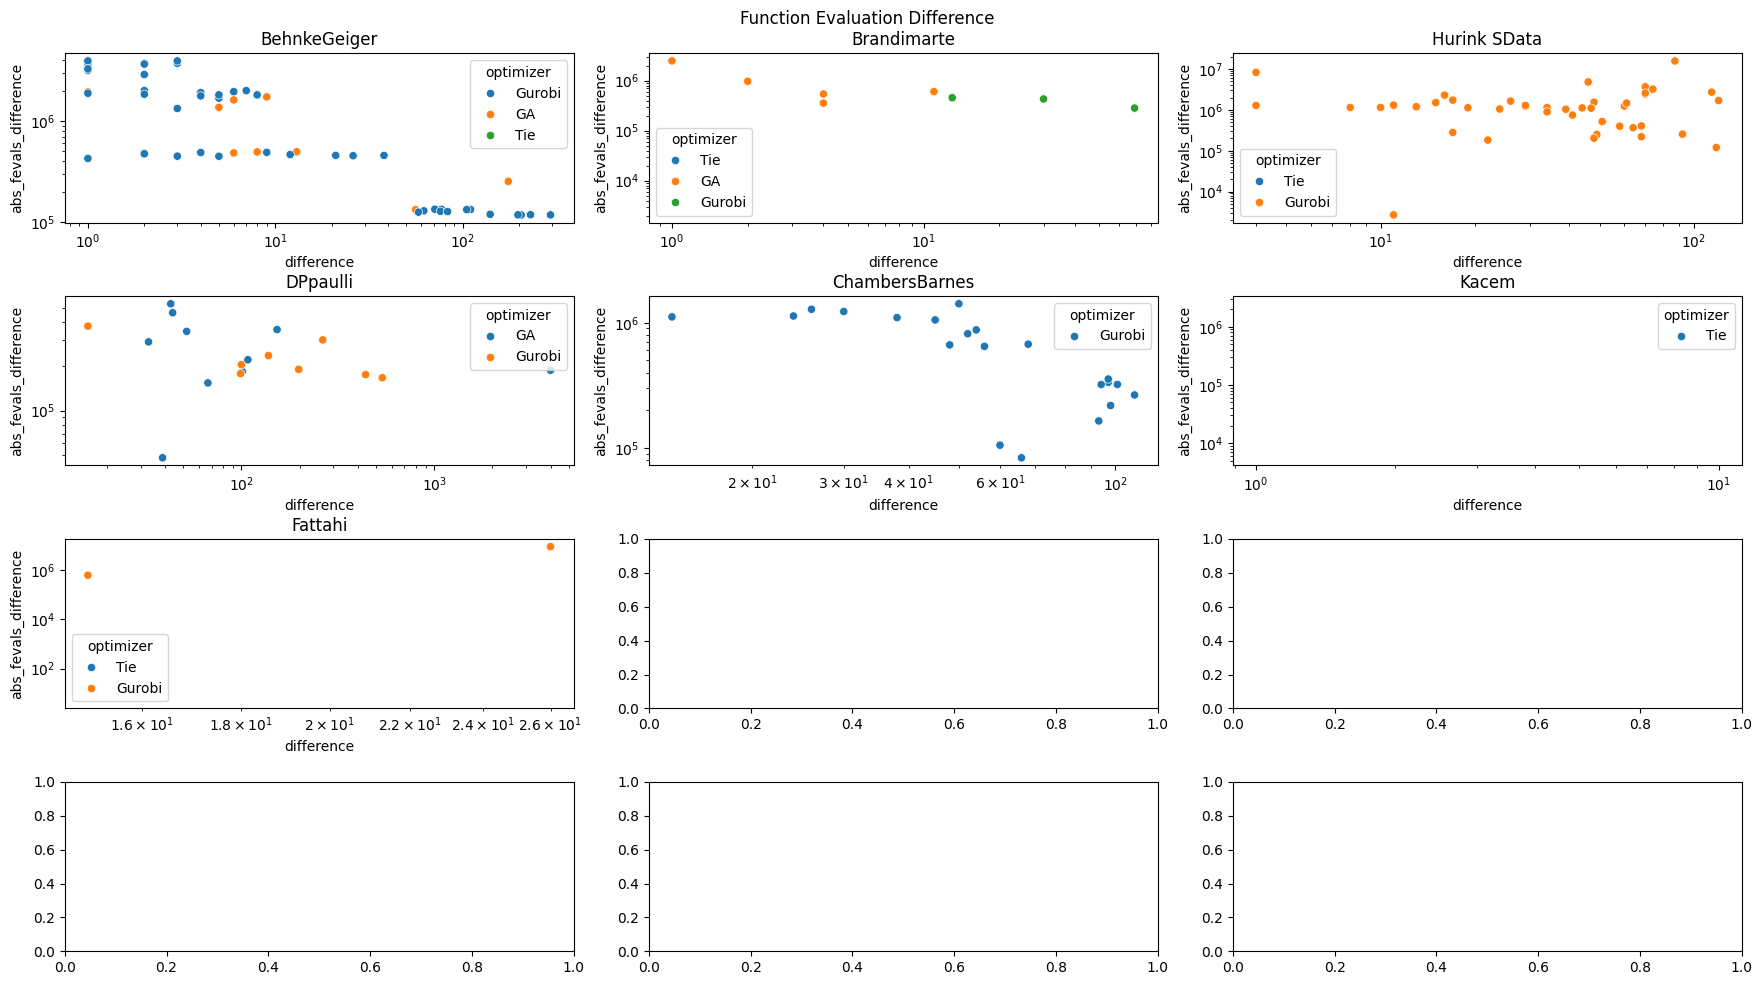

In [453]:
fig, axes = plt.subplots(4, 3, figsize=(18, 10))

fig.suptitle('Function Evaluation Difference')
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '0_BehnkeGeiger')], x='difference', y='abs_fevals_difference', ax=axes[0,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '1_Brandimarte')], x='difference', y='abs_fevals_difference', ax=axes[0,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '2a_Hurink_sdata')], x='difference', y='abs_fevals_difference', ax=axes[0,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '3_DPpaulli')], x='difference', y='abs_fevals_difference', ax=axes[1,0])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '4_ChambersBarnes')], x='difference', y='abs_fevals_difference', ax=axes[1,1])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '5_Kacem')], x='difference', y='abs_fevals_difference', ax=axes[1,2])
sns.scatterplot(hue='optimizer', data=df_diff.loc[(df_diff['source'] == '6_Fattahi')], x='difference', y='abs_fevals_difference', ax=axes[2,0])
fig.tight_layout()
axes[0,0].set_title('BehnkeGeiger')
#axes[0,0].set_yscale('function', functions=(absolute, absolute))
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')
axes[0,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,1].set_title('Brandimarte')
axes[0,1].set_yscale('log')
axes[0,1].set_xscale('log')
axes[0,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[0,2].set_title('Hurink SData')
axes[0,2].set_yscale('log')
axes[0,2].set_xscale('log')
axes[0,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,0].set_title('DPpaulli')
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,1].set_title('ChambersBarnes')
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[1,2].set_title('Kacem')
axes[1,2].set_yscale('log')
axes[1,2].set_xscale('log')
axes[1,2].axhline(y=0, color='r', linestyle='-', alpha=0.3)
axes[2,0].set_title('Fattahi')
axes[2,0].set_yscale('log')
axes[2,0].set_xscale('log')
axes[2,0].axhline(y=0, color='r', linestyle='-', alpha=0.3)

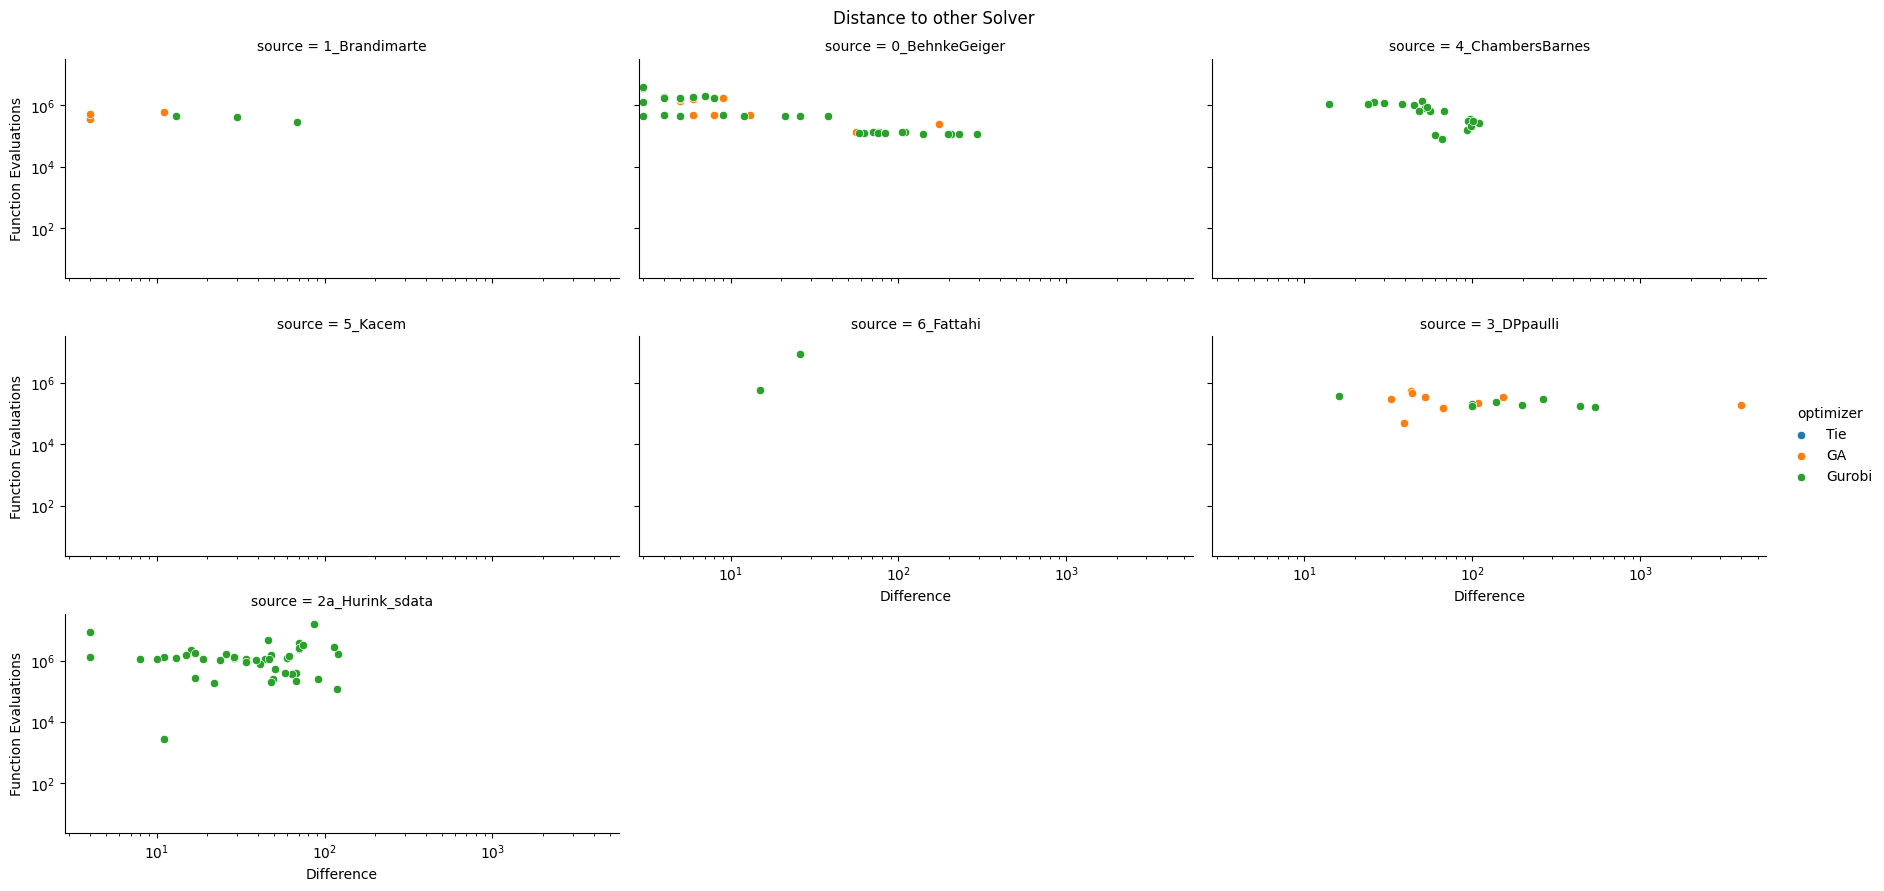

In [454]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='difference', y='abs_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Function Evaluations')
fg.set_xlabels('Difference')
plt.xscale('log')
plt.yscale('log')
plt.show(fg)

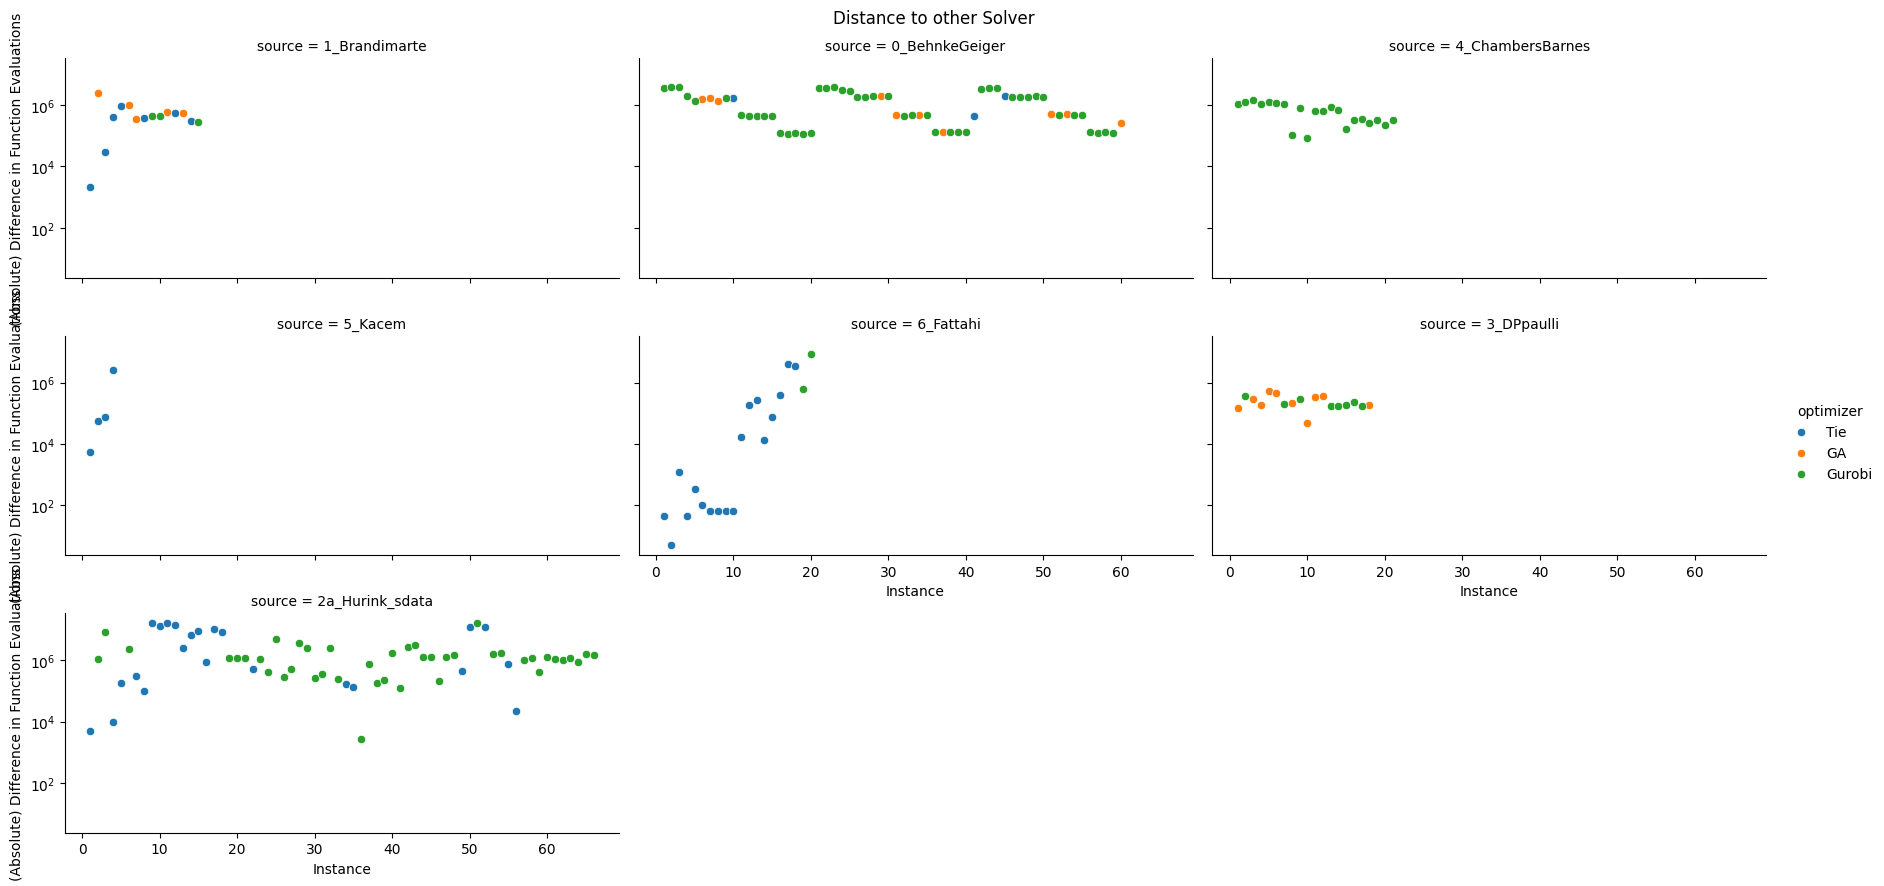

In [455]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='instance', y='abs_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('(Absolute) Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('log')
plt.show(fg)

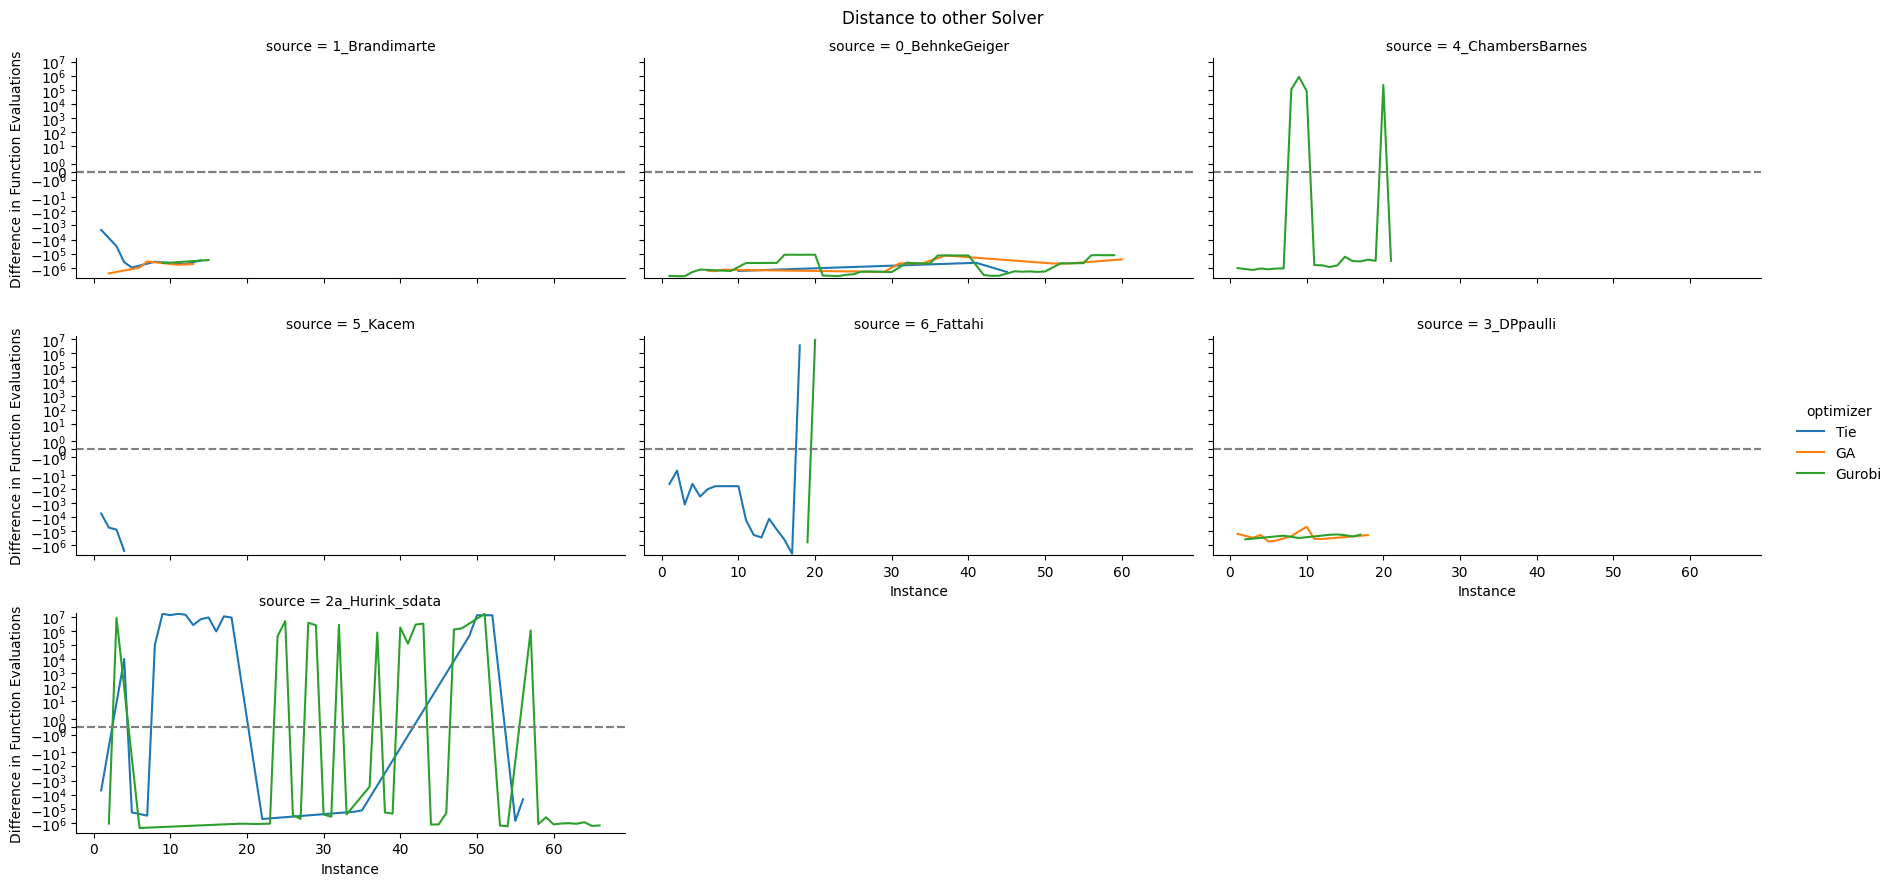

In [456]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.lineplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

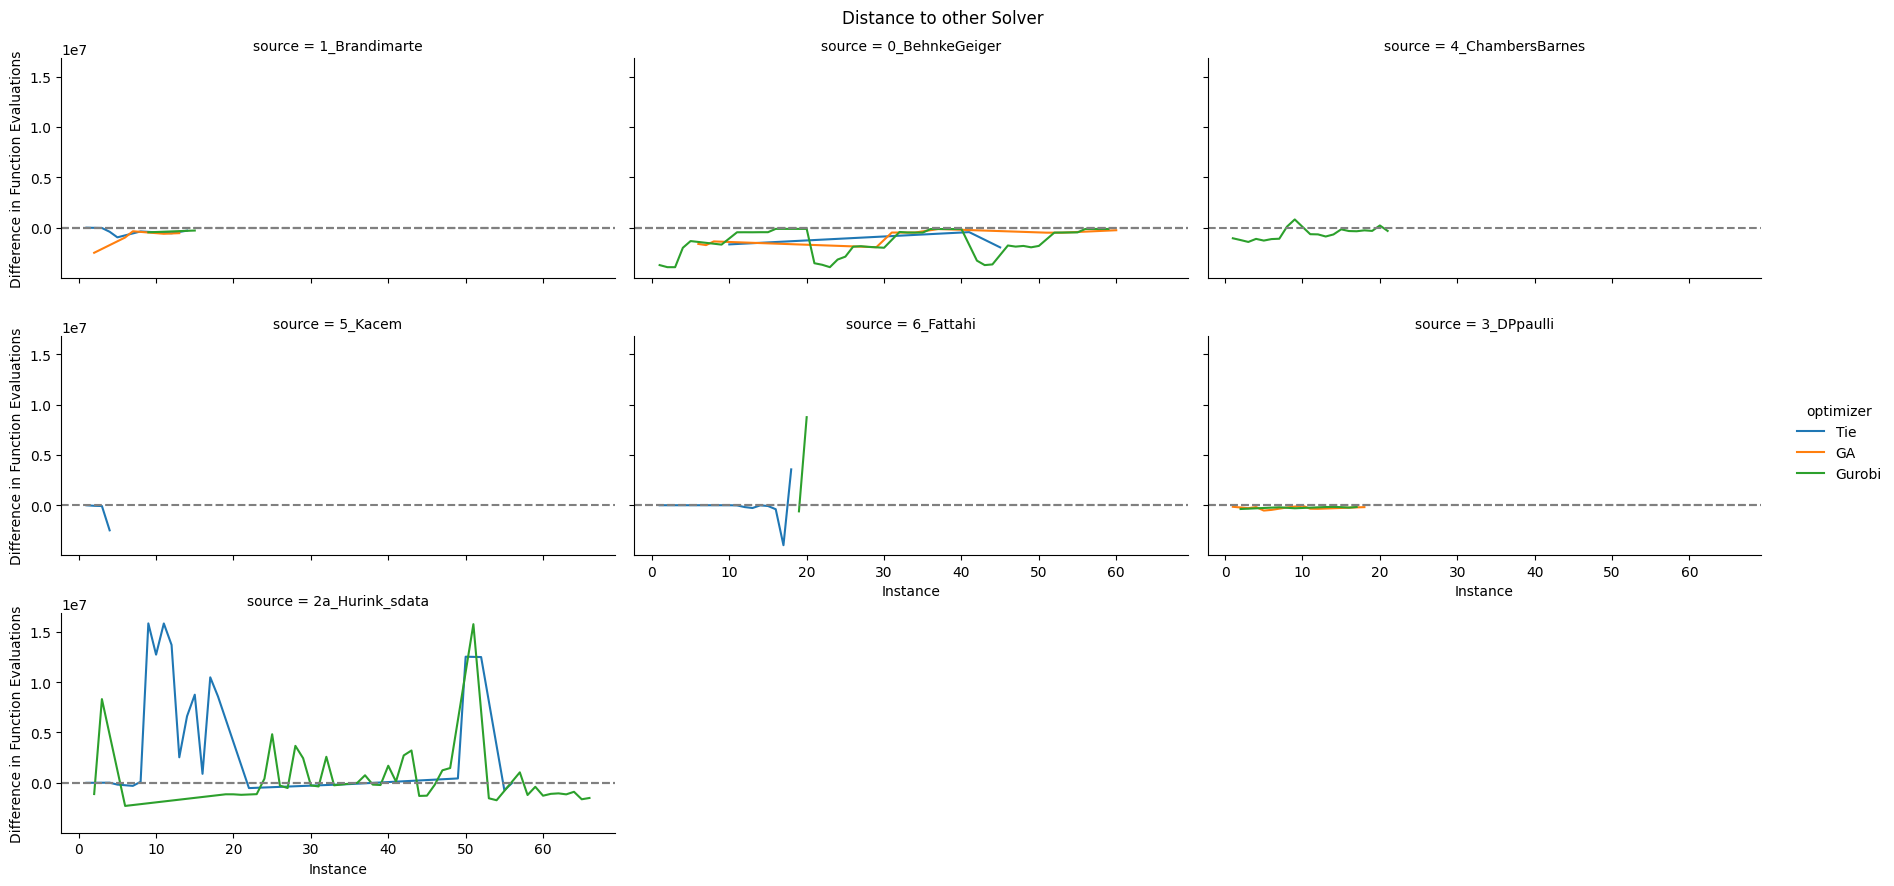

In [457]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.lineplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
#plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

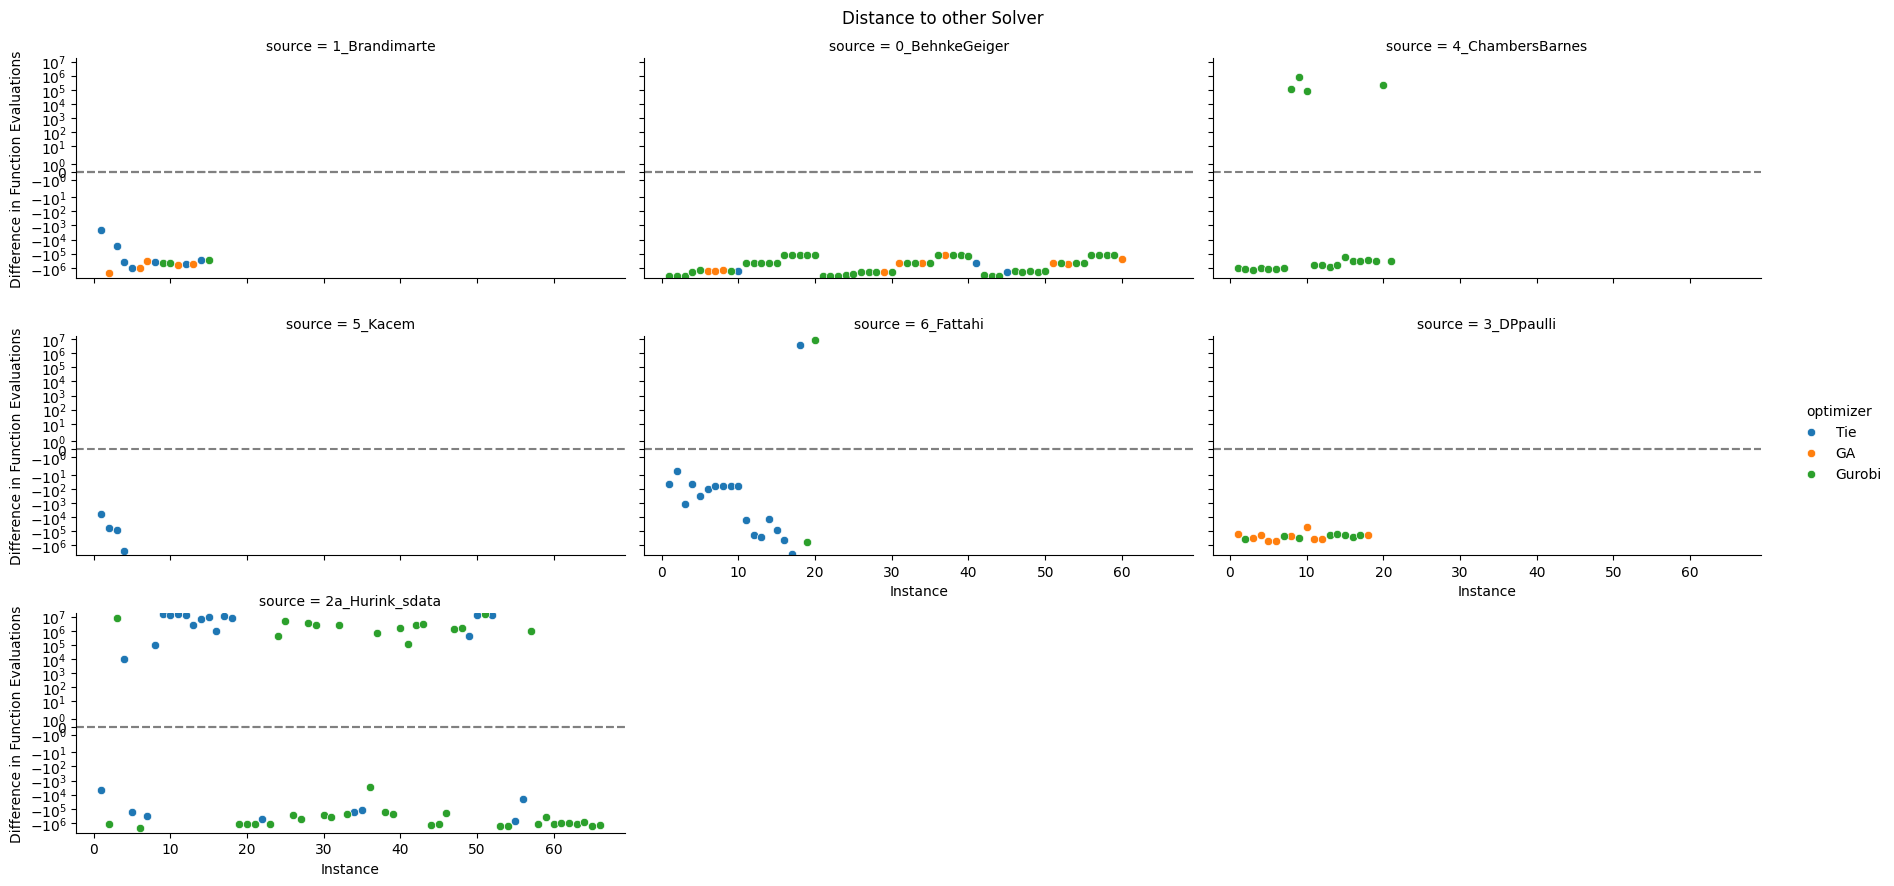

In [458]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Distance to other Solver")
fg.map_dataframe(sns.scatterplot, x='instance', y='fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')
#plt.xscale('log')
plt.yscale('symlog')
fg.refline(y=0)
plt.show(fg)

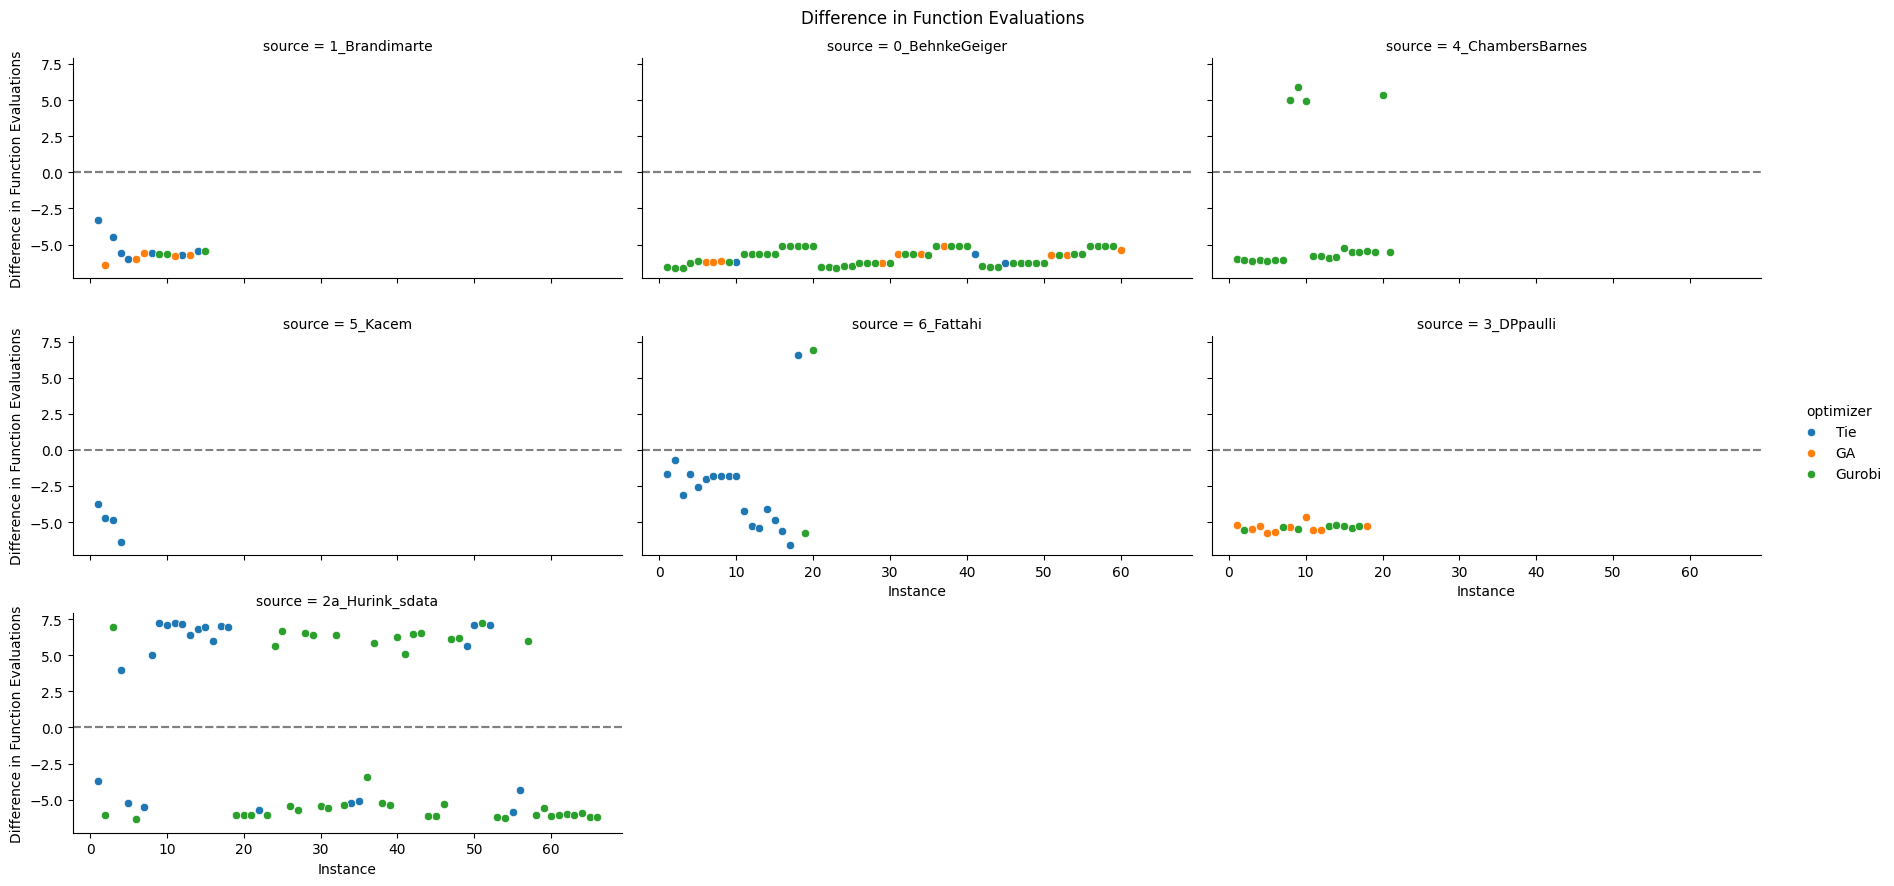

In [482]:
fg = sns.FacetGrid(data=df_diff, hue='optimizer', aspect=2, col='source', col_wrap=3)
fg.fig.suptitle("Difference in Function Evaluations")
fg.map_dataframe(sns.scatterplot, x='instance', y='log_fevals_difference').add_legend()
#fg.map_dataframe(sns.scatterplot, x='difference', y='fevals_GA', color='blue')
fg.set_ylabels('Difference in Function Evaluations')
fg.set_xlabels('Instance')

fg.refline(y=0)
plt.show(fg)

In [480]:
math.log(1117729)/math.log(10)

6.048336519050205

In [476]:
df_diff.loc[df_diff['source'] == '2a_Hurink_sdata']['abs_fevals_difference']

138        4949
139     1117729
140     8306472
141        9985
142      179545
143     2298385
144      305845
145       99977
146    15824628
147    12724176
148    15819111
149    13689113
150     2531233
151     6609957
152     8748636
153      889066
154    10471060
155     8573152
156     1142218
157     1144989
158     1194365
159      526984
160     1129182
161      404610
162     4819832
163      279693
164      519111
165     3667893
166     2439330
167      254829
168      365326
169     2582094
170      250433
171      162021
172      129542
173        2689
174      745957
175      181840
176      219941
177     1693795
178      120359
179     2716072
180     3207260
181     1304876
182     1279726
183      202964
184     1239804
185     1464672
186      431061
187    12519208
188    15749834
189    12484516
190     1539590
191     1733198
192      729470
193       21294
194     1037791
195     1214275
196      398498
197     1282066
198     1099047
199     1050618
200     

In [460]:
df_diff.sort_values(by=['difference'], ascending=False)

source  instance                 uid  best_objective  \
137        3_DPpaulli        18        3_DPpaulli18          2965.0   
133        3_DPpaulli        14        3_DPpaulli14          2862.0   
136        3_DPpaulli        17        3_DPpaulli17          2833.0   
33     0_BehnkeGeiger        19    0_BehnkeGeiger19           838.0   
128        3_DPpaulli         9         3_DPpaulli9          2484.0   
30     0_BehnkeGeiger        16    0_BehnkeGeiger16           831.0   
31     0_BehnkeGeiger        17    0_BehnkeGeiger17           801.0   
134        3_DPpaulli        15        3_DPpaulli15          2923.0   
34     0_BehnkeGeiger        20    0_BehnkeGeiger20           825.0   
95     0_BehnkeGeiger        60    0_BehnkeGeiger60           534.0   
131        3_DPpaulli        12        3_DPpaulli12          2311.0   
32     0_BehnkeGeiger        18    0_BehnkeGeiger18           821.0   
135        3_DPpaulli        16        3_DPpaulli16          2588.0   
177   2a_Hurink_sdata        40   2a_Hurink_sdata40          1517.0   
178   2a_Hurink_sdata        41   2a_Hurink_sdata41          1325.0   
179   2a_Hurink_sdata        42   2a_Hurink_sdata42          1347.0   
50     0_BehnkeGeiger        36    0_BehnkeGeiger36           578.0   
89   4_ChambersBarnes        18  4_ChambersBarnes18          1244.0   
127        3_DPpaulli         8         3_DPpaulli8          2197.0   
52     0_BehnkeGeiger        38    0_BehnkeGeiger38           552.0   
92   4_ChambersBarnes        21  4_ChambersBarnes21          1236.0   
123        3_DPpaulli         4         3_DPpaulli4          2600.0   
126        3_DPpaulli         7         3_DPpaulli7          2672.0   
132        3_DPpaulli        13        3_DPpaulli13          2648.0   
91   4_ChambersBarnes        20  4_ChambersBarnes20          1268.0   
88   4_ChambersBarnes        17  4_ChambersBarnes17          1294.0   
87   4_ChambersBarnes        16  4_ChambersBarnes16          1305.0   
90   4_ChambersBarnes        19  4_ChambersBarnes19          1219.0   
86   4_ChambersBarnes        15  4_ChambersBarnes15          1294.0   
167   2a_Hurink_sdata        30   2a_Hurink_sdata30          1347.0   
188   2a_Hurink_sdata        51   2a_Hurink_sdata51          7399.0   
94     0_BehnkeGeiger        59    0_BehnkeGeiger59           530.0   
53     0_BehnkeGeiger        39    0_BehnkeGeiger39           555.0   
93     0_BehnkeGeiger        58    0_BehnkeGeiger58           542.0   
180   2a_Hurink_sdata        43   2a_Hurink_sdata43          1309.0   
54     0_BehnkeGeiger        40    0_BehnkeGeiger40           575.0   
165   2a_Hurink_sdata        28   2a_Hurink_sdata28          1047.0   
166   2a_Hurink_sdata        29   2a_Hurink_sdata29          1288.0   
169   2a_Hurink_sdata        32   2a_Hurink_sdata32          1304.0   
14      1_Brandimarte        15     1_Brandimarte15           430.0   
161   2a_Hurink_sdata        24   2a_Hurink_sdata24          1124.0   
176   2a_Hurink_sdata        39   2a_Hurink_sdata39          1336.0   
85   4_ChambersBarnes        14  4_ChambersBarnes14           975.0   
120        3_DPpaulli         1         3_DPpaulli1          2606.0   
81   4_ChambersBarnes        10  4_ChambersBarnes10           991.0   
168   2a_Hurink_sdata        31   2a_Hurink_sdata31          1305.0   
70     0_BehnkeGeiger        56    0_BehnkeGeiger56           533.0   
185   2a_Hurink_sdata        48   2a_Hurink_sdata48           778.0   
184   2a_Hurink_sdata        47   2a_Hurink_sdata47           777.0   
79   4_ChambersBarnes         8   4_ChambersBarnes8           985.0   
71     0_BehnkeGeiger        57    0_BehnkeGeiger57           535.0   
196   2a_Hurink_sdata        59   2a_Hurink_sdata59          1063.0   
51     0_BehnkeGeiger        37    0_BehnkeGeiger37           566.0   
82   4_ChambersBarnes        11  4_ChambersBarnes11           966.0   
84   4_ChambersBarnes        13  4_ChambersBarnes13           968.0   
80   4_ChambersBarnes         9   4_Cha

In [461]:
pd.options.display.max_rows = 500
df_diff.loc[:, ['source', 'instance', 'optimizer', 'difference']].loc[df_diff['difference'] > 0].sort_values(by=['difference'], ascending=False)

source  instance optimizer  difference
137        3_DPpaulli        18        GA      4000.0
133        3_DPpaulli        14    Gurobi       537.0
136        3_DPpaulli        17    Gurobi       440.0
33     0_BehnkeGeiger        19    Gurobi       294.0
128        3_DPpaulli         9    Gurobi       264.0
30     0_BehnkeGeiger        16    Gurobi       230.0
31     0_BehnkeGeiger        17    Gurobi       205.0
134        3_DPpaulli        15    Gurobi       198.0
34     0_BehnkeGeiger        20    Gurobi       197.0
95     0_BehnkeGeiger        60        GA       175.0
131        3_DPpaulli        12        GA       153.0
32     0_BehnkeGeiger        18    Gurobi       140.0
135        3_DPpaulli        16    Gurobi       138.0
177   2a_Hurink_sdata        40    Gurobi       120.0
178   2a_Hurink_sdata        41    Gurobi       118.0
179   2a_Hurink_sdata        42    Gurobi       114.0
50     0_BehnkeGeiger        36    Gurobi       110.0
89   4_ChambersBarnes        18    Gurobi       109.0
127        3_DPpaulli         8        GA       108.0
52     0_BehnkeGeiger        38    Gurobi       105.0
123        3_DPpaulli         4        GA       101.0
92   4_ChambersBarnes        21    Gurobi       101.0
126        3_DPpaulli         7    Gurobi       100.0
132        3_DPpaulli        13    Gurobi        99.0
91   4_ChambersBarnes        20    Gurobi        98.0
87   4_ChambersBarnes        16    Gurobi        97.0
88   4_ChambersBarnes        17    Gurobi        97.0
90   4_ChambersBarnes        19    Gurobi        94.0
86   4_ChambersBarnes        15    Gurobi        93.0
167   2a_Hurink_sdata        30    Gurobi        92.0
188   2a_Hurink_sdata        51    Gurobi        87.0
94     0_BehnkeGeiger        59    Gurobi        83.0
53     0_BehnkeGeiger        39    Gurobi        77.0
93     0_BehnkeGeiger        58    Gurobi        76.0
180   2a_Hurink_sdata        43    Gurobi        74.0
54     0_BehnkeGeiger        40    Gurobi        71.0
169   2a_Hurink_sdata        32    Gurobi        70.0
166   2a_Hurink_sdata        29    Gurobi        70.0
165   2a_Hurink_sdata        28    Gurobi        70.0
14      1_Brandimarte        15    Gurobi        69.0
161   2a_Hurink_sdata        24    Gurobi        68.0
85   4_ChambersBarnes        14    Gurobi        68.0
176   2a_Hurink_sdata        39    Gurobi        68.0
120        3_DPpaulli         1        GA        67.0
81   4_ChambersBarnes        10    Gurobi        66.0
168   2a_Hurink_sdata        31    Gurobi        64.0
70     0_BehnkeGeiger        56    Gurobi        62.0
185   2a_Hurink_sdata        48    Gurobi        61.0
79   4_ChambersBarnes         8    Gurobi        60.0
184   2a_Hurink_sdata        47    Gurobi        60.0
71     0_BehnkeGeiger        57    Gurobi        58.0
196   2a_Hurink_sdata        59    Gurobi        58.0
51     0_BehnkeGeiger        37        GA        56.0
82   4_ChambersBarnes        11    Gurobi        56.0
84   4_ChambersBarnes        13    Gurobi        54.0
130        3_DPpaulli        11        GA        52.0
80   4_ChambersBarnes         9    Gurobi        52.0
164   2a_Hurink_sdata        27    Gurobi        51.0
74   4_ChambersBarnes         3    Gurobi        50.0
170   2a_Hurink_sdata        33    Gurobi        49.0
190   2a_Hurink_sdata        53    Gurobi        48.0
183   2a_Hurink_sdata        46    Gurobi        48.0
83   4_ChambersBarnes        12    Gurobi        48.0
198   2a_Hurink_sdata        61    Gurobi        47.0
162   2a_Hurink_sdata        25    Gurobi        46.0
72   4_ChambersBarnes         1    Gurobi        45.0
139   2a_Hurink_sdata         2    Gurobi        44.0
125        3_DPpaulli         6        GA        44.0
124        3_DPpaulli         5        GA        43.0
174   2a_Hurink_sdata        37    Gurobi        41.0
194   2a_Hurink_sdata        57    Gurobi        39.0
129        3_DPpaulli        10        GA        39.0
27     0_BehnkeGeiger        13    Gurobi        38.0
78   4_ChambersBarn

In [462]:
df_diff.loc[df_diff['difference'] == 0]

source  instance                uid  best_objective  n_machines  \
0      1_Brandimarte         1     1_Brandimarte1            40.0           6   
2      1_Brandimarte         3     1_Brandimarte3           204.0           8   
3      1_Brandimarte         4     1_Brandimarte4            60.0           8   
4      1_Brandimarte         5     1_Brandimarte5           173.0           4   
7      1_Brandimarte         8     1_Brandimarte8           523.0          10   
11     1_Brandimarte        12    1_Brandimarte12           508.0          10   
13     1_Brandimarte        14    1_Brandimarte14           694.0          15   
24    0_BehnkeGeiger        10   0_BehnkeGeiger10           140.0          20   
55    0_BehnkeGeiger        41   0_BehnkeGeiger41            87.0          60   
59    0_BehnkeGeiger        45   0_BehnkeGeiger45            87.0          60   
96           5_Kacem         1           5_Kacem1            11.0           5   
97           5_Kacem         2           5_Kacem2            11.0           7   
98           5_Kacem         3           5_Kacem3             7.0          10   
99           5_Kacem         4           5_Kacem4            11.0          10   
100        6_Fattahi         1         6_Fattahi1            66.0           2   
101        6_Fattahi         2         6_Fattahi2           107.0           2   
102        6_Fattahi         3         6_Fattahi3           221.0           2   
103        6_Fattahi         4         6_Fattahi4           355.0           2   
104        6_Fattahi         5         6_Fattahi5           119.0           2   
105        6_Fattahi         6         6_Fattahi6           320.0           3   
106        6_Fattahi         7         6_Fattahi7           397.0           5   
107        6_Fattahi         8         6_Fattahi8           253.0           4   
108        6_Fattahi         9         6_Fattahi9           210.0           3   
109        6_Fattahi        10        6_Fattahi10           516.0           5   
110        6_Fattahi        11        6_Fattahi11           468.0           6   
111        6_Fattahi        12        6_Fattahi12           446.0           7   
112        6_Fattahi        13        6_Fattahi13           466.0           7   
113        6_Fattahi        14        6_Fattahi14           554.0           7   
114        6_Fattahi        15        6_Fattahi15           514.0           7   
115        6_Fattahi        16        6_Fattahi16           634.0           7   
116        6_Fattahi        17        6_Fattahi17           879.0           7   
117        6_Fattahi        18        6_Fattahi18           884.0           8   
138  2a_Hurink_sdata         1   2a_Hurink_sdata1            55.0           6   
141  2a_Hurink_sdata         4   2a_Hurink_sdata4           666.0           5   
142  2a_Hurink_sdata         5   2a_Hurink_sdata5           655.0           5   
144  2a_Hurink_sdata         7   2a_Hurink_sdata7           590.0           5   
145  2a_Hurink_sdata         8   2a_Hurink_sdata8           593.0           5   
146  2a_Hurink_sdata         9   2a_Hurink_sdata9           926.0           5   
147  2a_Hurink_sdata        10  2a_Hurink_sdata10           890.0           5   
148  2a_Hurink_sdata        11  2a_Hurink_sdata11           863.0           5   
149  2a_Hurink_sdata        12  2a_Hurink_sdata12           951.0           5   
150  2a_Hurink_sdata        13  2a_Hurink_sdata13           958.0           5   
151  2a_Hurink_sdata        14  2a_Hurink_sdata14          1222.0           5   
152  2a_Hurink_sdata        15  2a_Hurink_sdata15          1039.0           5   
153  2a_Hurink_sdata        16  2a_Hurink_sdata16          1150.0           5   
154  2a_Hurink_sdata        17  2a_Hurink_sdata17          1292.0           5   
155  2a_Hurink_sdata        18  2a_Hurink_sdata18          1207.0           5   
159  2a_Hurink_sdata        22  2a_Hurink_sdata22           842.0          10   
171  2a_Hurink_sdata        34  2a_Hurink_sda

In [463]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['difference'], ascending=False)

source  instance  best_objective optimizer  difference
33  0_BehnkeGeiger        19           838.0    Gurobi       294.0
30  0_BehnkeGeiger        16           831.0    Gurobi       230.0
31  0_BehnkeGeiger        17           801.0    Gurobi       205.0
34  0_BehnkeGeiger        20           825.0    Gurobi       197.0
95  0_BehnkeGeiger        60           534.0        GA       175.0
32  0_BehnkeGeiger        18           821.0    Gurobi       140.0
50  0_BehnkeGeiger        36           578.0    Gurobi       110.0
52  0_BehnkeGeiger        38           552.0    Gurobi       105.0
94  0_BehnkeGeiger        59           530.0    Gurobi        83.0
53  0_BehnkeGeiger        39           555.0    Gurobi        77.0
93  0_BehnkeGeiger        58           542.0    Gurobi        76.0
54  0_BehnkeGeiger        40           575.0    Gurobi        71.0
70  0_BehnkeGeiger        56           533.0    Gurobi        62.0
71  0_BehnkeGeiger        57           535.0    Gurobi        58.0
51  0_BehnkeGeiger        37           566.0        GA        56.0
27  0_BehnkeGeiger        13           316.0    Gurobi        38.0
26  0_BehnkeGeiger        12           324.0    Gurobi        26.0
25  0_BehnkeGeiger        11           315.0    Gurobi        21.0
67  0_BehnkeGeiger        53           253.0        GA        13.0
69  0_BehnkeGeiger        55           265.0    Gurobi        12.0
21  0_BehnkeGeiger         7           136.0        GA         9.0
66  0_BehnkeGeiger        52           256.0    Gurobi         9.0
65  0_BehnkeGeiger        51           257.0        GA         8.0
64  0_BehnkeGeiger        50           133.0    Gurobi         8.0
44  0_BehnkeGeiger        30           130.0    Gurobi         7.0
63  0_BehnkeGeiger        49           122.0    Gurobi         6.0
20  0_BehnkeGeiger         6           136.0        GA         6.0
48  0_BehnkeGeiger        34           267.0        GA         6.0
62  0_BehnkeGeiger        48           133.0    Gurobi         5.0
28  0_BehnkeGeiger        14           324.0    Gurobi         5.0
22  0_BehnkeGeiger         8           133.0        GA         5.0
23  0_BehnkeGeiger         9           135.0    Gurobi         5.0
49  0_BehnkeGeiger        35           258.0    Gurobi         4.0
40  0_BehnkeGeiger        26           122.0    Gurobi         4.0
42  0_BehnkeGeiger        28           125.0    Gurobi         4.0
60  0_BehnkeGeiger        46           124.0    Gurobi         4.0
19  0_BehnkeGeiger         5            94.0    Gurobi         3.0
29  0_BehnkeGeiger        15           300.0    Gurobi         3.0
16  0_BehnkeGeiger         2            94.0    Gurobi         3.0
15  0_BehnkeGeiger         1            93.0    Gurobi         3.0
68  0_BehnkeGeiger        54           265.0    Gurobi         2.0
18  0_BehnkeGeiger         4            99.0    Gurobi         2.0
41  0_BehnkeGeiger        27           131.0    Gurobi         2.0
57  0_BehnkeGeiger        43            88.0    Gurobi         2.0
39  0_BehnkeGeiger        25            89.0    Gurobi         2.0
47  0_BehnkeGeiger        33           264.0    Gurobi         2.0
45  0_BehnkeGeiger        31           280.0        GA         2.0
58  0_BehnkeGeiger        44            86.0    Gurobi         2.0
61  0_BehnkeGeiger        47           123.0    Gurobi         1.0
56  0_BehnkeGeiger        42            88.0    Gurobi         1.0
35  0_BehnkeGeiger        21            89.0    Gurobi         1.0
36  0_BehnkeGeiger        22            88.0    Gurobi         1.0
37  0_BehnkeGeiger        23            86.0    Gurobi         1.0
38  0_BehnkeGeiger        24            88.0    Gurobi         1.0
46  0_BehnkeGeiger        32           264.0    Gurobi         1.0
43  0_BehnkeGeiger        29           123.0        GA         1.0
17  0_BehnkeGeiger         3            92.0    Gurobi         1.0

In [464]:
df_diff.loc[:, ['source', 'instance', 'best_objective', 'fevals_GA', 'fevals_Gurobi', 'optimizer', 'difference']].loc[(df_diff['difference'] > 0) & (df_diff['source'] == '0_BehnkeGeiger')].sort_values(by=['optimizer'], ascending=False)

source  instance  best_objective  fevals_GA  fevals_Gurobi  \
15  0_BehnkeGeiger         1            93.0    3874440         158083   
60  0_BehnkeGeiger        46           124.0    1931660         162689   
46  0_BehnkeGeiger        32           264.0     429605           2802   
47  0_BehnkeGeiger        33           264.0     482805           2618   
49  0_BehnkeGeiger        35           258.0     491065           2320   
50  0_BehnkeGeiger        36           578.0     133615             61   
52  0_BehnkeGeiger        38           552.0     133435             31   
53  0_BehnkeGeiger        39           555.0     134375            106   
54  0_BehnkeGeiger        40           575.0     135295            749   
56  0_BehnkeGeiger        42            88.0    3985850         712018   
57  0_BehnkeGeiger        43            88.0    3778490          62715   
58  0_BehnkeGeiger        44            86.0    3771690         123617   
61  0_BehnkeGeiger        47           123.0    1970180          90056   
42  0_BehnkeGeiger        28           125.0    1963140          56007   
62  0_BehnkeGeiger        48           133.0    1904500          92885   
63  0_BehnkeGeiger        49           122.0    1994760          45113   
64  0_BehnkeGeiger        50           133.0    1825000          13655   
66  0_BehnkeGeiger        52           256.0     493505           2924   
68  0_BehnkeGeiger        54           265.0     486905          12670   
69  0_BehnkeGeiger        55           265.0     468865           2356   
70  0_BehnkeGeiger        56           533.0     130135            392   
71  0_BehnkeGeiger        57           535.0     125915             31   
93  0_BehnkeGeiger        58           542.0     128455             31   
94  0_BehnkeGeiger        59           530.0     127935            363   
16  0_BehnkeGeiger         2            94.0    4096625         175969   
44  0_BehnkeGeiger        30           130.0    2061565          68188   
41  0_BehnkeGeiger        27           131.0    2039505         201308   
32  0_BehnkeGeiger        18           821.0     120055            201   
17  0_BehnkeGeiger         3            92.0    4011785          87914   
18  0_BehnkeGeiger         4            99.0    4038785        2042111   
19  0_BehnkeGeiger         5            94.0    4038500        2708987   
23  0_BehnkeGeiger         9           135.0    1989420         308150   
25  0_BehnkeGeiger        11           315.0     462505           4758   
26  0_BehnkeGeiger        12           324.0     457225           3174   
27  0_BehnkeGeiger        13           316.0     460085           3154   
28  0_BehnkeGeiger        14           324.0     458825          10471   
29  0_BehnkeGeiger        15           300.0     461565          12069   
31  0_BehnkeGeiger        17           801.0     118335             81   
30  0_BehnkeGeiger        16           831.0     119115            272   
33  0_BehnkeGeiger        19           838.0     119035            694   
37  0_BehnkeGeiger        23            86.0    3994590          74280   
40  0_BehnkeGeiger        26           122.0    1978160          89238   
39  0_BehnkeGeiger        25            89.0    3798745         922555   
34  0_BehnkeGeiger        20           825.0     118955            504   
38  0_BehnkeGeiger        24            88.0    3856145         691451   
36  0_BehnkeGeiger        22            88.0    3790005         107355   
35  0_BehnkeGeiger        21            89.0    4036470         505474   
48  0_BehnkeGeiger        34           267.0     486985           3105   
65  0_BehnkeGeiger        51           257.0     497645           2687   
51  0_BehnkeGeiger        37           566.0     133455            297   
67  0_BehnkeGeiger        53           253.0     499685           3129   
22  0_BehnkeGeiger         8           133.0    1893680         528464   
21  0_BehnkeGeiger         7           136.0    1874560         144931   
20  0_BehnkeGeig

In [488]:
df_diff.loc[:, ['source', 'instance', 'beta_flexibility', 'duration_variety', 'n_machines', 'n_operations', 'n_job']].loc[df_diff['source'] == '6_Fattahi']

source  instance  beta_flexibility  duration_variety  n_machines  \
100  6_Fattahi         1          1.000000          0.875000           2   
101  6_Fattahi         2          0.750000          0.833333           2   
102  6_Fattahi         3          0.850000          0.900000           2   
103  6_Fattahi         4          0.850000          1.000000           2   
104  6_Fattahi         5          1.000000          0.750000           2   
105  6_Fattahi         6          0.533333          0.866667           3   
106  6_Fattahi         7          0.400000          0.944444           5   
107  6_Fattahi         8          0.500000          0.944444           4   
108  6_Fattahi         9          0.666667          0.555556           3   
109  6_Fattahi        10          0.340000          0.850000           5   
110  6_Fattahi        11          0.366667          0.787879           6   
111  6_Fattahi        12          0.385714          0.743590           7   
112  6_Fattahi        13          0.385714          0.708333           7   
113  6_Fattahi        14          0.385714          0.714286           7   
114  6_Fattahi        15          0.371429          0.690909           7   
115  6_Fattahi        16          0.371429          0.677419           7   
116  6_Fattahi        17          0.342857          0.589744           7   
117  6_Fattahi        18          0.300000          0.546512           8   
118  6_Fattahi        19          0.287500          0.456311           8   
119  6_Fattahi        20          0.287500          0.455357           8   

     n_operations  n_job  
100             4      2  
101             4      2  
102             6      3  
103             6      3  
104             6      3  
105             9      3  
106             9      3  
107             9      3  
108             9      3  
109            12      4  
110            15      5  
111            15      5  
112            18      6  
113            21      7  
114            21      7  
115            24      8  
116            32      8  
117            36      9  
118            44     11  
119            48     12